# Setup

## Imports

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

## **Raw data**



### Downloading data


We use the Adience dataset consisting unfiltered faces ([Link](http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz)). Then, we unzip it.  
The first cell below downloads the data for you and places it in the **data** directory. The second cell unzips the data.

### Downloading folds

All five folds used in this paper are present [here](https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold). Download the **train_val_txt_files_per_fold** folder and place it in **My Drive/AgeGenderClassification/data**.


## Data loading

In [3]:
PATH_TO_FOLDS = "data/train_val_txt_files_per_fold"
PATH_TO_DATA = "data/"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "aligned/"

In [4]:
# Notify me on completion by sound
from IPython.display import Audio
sound_file = '/root/beep-07a.wav'

#Audio(sound_file, autoplay=True)

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.

[This](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a useful tutorial on how to load and augment data in PyTorch. 

In [5]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split() 
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }
    
class AdienceDatasetCombined(Dataset):
    
    def __init__(self, txt_dir, subset, root_dir, transform):
        self.txt_dir = txt_dir
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        data2 = []
        age_txt_file = f'{self.txt_dir}/age_{self.subset}.txt'
        gender_txt_file = f'{self.txt_dir}/gender_{self.subset}.txt'
        age_file = open(age_txt_file)        
        for line in age_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            data.append((image_file, label))
        age_file.close()
        gender_file = open(gender_txt_file)
        for line in gender_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            for record in data:
                if (record[0] == image_file):
                    data2.append((image_file, record[1] + 10*label))
                    break
        return data2
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [6]:
transforms_list = [
    transforms.Resize(256), # 0 (required)
    transforms.CenterCrop(227), #1 (required)
    transforms.RandomHorizontalFlip(), #2
    transforms.ToTensor(), #3 (required)
    transforms.RandomCrop(227) #4
]

# Adversarial training
# Look into increase or decrease contrast
# Look into principal component analysis (PCA) on the RGB colourspace

# Pre-training using the CelebA dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# Essentially, meaning getting parameters but not calculating accuracy

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [7]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender", or 'both'
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    root_dir = PATH_TO_IMAGE_FOLDERS
    if c == "both":
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}'
        transformed_dataset = AdienceDatasetCombined(txt_file, s, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader
    else:
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'        
        transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader    

# Network

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
PATH_TO_MODELS = "models_pca"

In [54]:
def convert_to_pca(original_image):
    #print(original_image.shape)
    renorm_image = np.reshape(original_image.cpu(),(original_image.shape[1]*original_image.shape[2],3))
    renorm_image = renorm_image.numpy()

    renorm_image = renorm_image.astype('float32')
    renorm_image -= np.mean(renorm_image, axis=0)
    renorm_image /= np.std(renorm_image, axis=0)

    cov = np.cov(renorm_image, rowvar=False)

    lambdas, p = np.linalg.eig(cov)
    alphas = np.random.normal(0, 0.1, 3)

    delta = np.dot(p, alphas*lambdas)

    mean = np.mean(renorm_image, axis=0)
    std = np.std(renorm_image, axis=0)
    pca_augmentation_version_renorm_image = renorm_image + delta
    pca_color_image = pca_augmentation_version_renorm_image * std + mean
    pca_color_image = np.maximum(np.minimum(pca_color_image, 255), 0).astype('uint8')
    pca_color_image = torch.from_numpy(pca_color_image)
    pca_color_image = pca_color_image.view(3, 227, 227)
    pca_color_image.to(device)
    #print(pca_color_image.shape)
    
    return pca_color_image

## Defining the network
This is the network as described in the [paper](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf).

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

class NewNet(nn.Module):
    
    def __init__(self):
        super(NewNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [13]:
criterion = nn.NLLLoss()

## Hyperparameters
Try playing with these! While the **`minibatch_size`** and **`lr`** are pulled from the paper, **`num_epochs`** is set empirically. 

In [14]:
minibatch_size = 50
num_epochs = 200
lr = 0.0001  # initial learning rate

## Training the network
We save the network to the drive and compute the loss on validation set after every **`checkpoint_frequency`** number of iterations. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [39]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency=50, val_dataloader=None, patience=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    best_iteration = 1
    best_validation_loss = np.inf
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            for count in range(len(images)):
                images[count] = convert_to_pca(images[count])
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            
            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                if patience == None:
                    training_loss.append(running_loss/checkpoint_frequency)
                    validation_loss.append(validate(net, val_dataloader))
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    save_network(net, f'{filename}_checkpoint{checkpoint}')                        
                elif patience > 0:
                    training_loss_result = running_loss/checkpoint_frequency
                    validation_loss_result = validate(net, val_dataloader)
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    if best_validation_loss >= validation_loss_result:
                        print(f'Best loss improvement from {best_validation_loss} to {validation_loss_result} in epoch {epoch+1}')
                        best_validation_loss = validation_loss_result
                        best_epoch = epoch + 1
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                        save_network(net, f'{filename}_checkpoint{checkpoint}')
                        best_iteration = iteration + 1
                    elif best_iteration + patience * checkpoint_frequency <= iteration:
                        print(f"Patience ran out at {iteration}. Ending training")
                        return net, training_loss, validation_loss
                    else:
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                checkpoint += 1
                running_loss = 0
            iteration += 1

    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [35]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            for count in range(len(images)):
                #images[count].cpu()
                images[count] = convert_to_pca(images[count])
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [17]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [34]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c != 'gender':
        result['one_off_match'] = 0
    if c == 'both':
        result['gender_match'] = 0
        result['age_match'] = 0
        result['one_off_age_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            for count in range(len(images)):
                #images[count].cpu()
                images[count] = convert_to_pca(images[count])
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c != 'gender':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()
            if c == 'both':
                for count, o in enumerate(outputs):
                    o = o.item()
                    if o <= 7: # male
                        if labels[count].item() >= 0 and labels[count].item() <= 7:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o + 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o + 8 or labels[count].item() == o + 6:
                            result['one_off_age_match'] += 1
                    elif o >= 10: # female
                        if labels[count].item() >= 10:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o - 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o - 8 or labels[count].item() == o - 6:
                            result['one_off_age_match'] += 1

    return result           

## Saving the network

In [19]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

### Picking the best model for a fold
**`train_save()`** trains the network using the **`train()`** function and then, using the validation losses returned by this function at all checkpoints, chooses the model with least validation error. This function also plots a graph of training and validation errors over the iterations.

**Usage:**

For e.g., if you want to train the network for **`age`** using **`fold=2`** and **`train_transform_index=2`**,
```
train_save('age', 2, 2)
```



In [20]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50, patience=10):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    if c != "both":
        trained_net, training_loss, validation_loss = train(
            Net().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss
    else:
        trained_net, training_loss, validation_loss = train(
            NewNet().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss

In [21]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory. 

**Usage:**

To pick the best model for **`age`**,
```
pick_best_model('age')
```


To pick the best model for **`gender`**,

```
pick_best_model('gender')
```

In [22]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age", "gender" or "both".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.

**Usage:**

To know the performance on **`age`** classification,
```
get_performance('age')
```


To know the performance on **`gender`** classification,

```
get_performance('gender')
```



In [23]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [24]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [25]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """
    filename = get_model_filename(c, fold, train_transform_index)
    if c != "both":
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        if c != 'gender':
            return {
                'accuracy': performance['exact_match']/performance['total'],
                'one-off accuracy': performance['one_off_match']/performance['total']
            }
        else:
            return {
                'accuracy': performance['exact_match']/performance['total']
            }
    else:
        net = NewNet().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'gender accuracy': performance['gender_match']/performance['total'],
            'age accuracy': performance['age_match']/performance['total'],
            'one-off age accuracy': performance['one_off_age_match']/performance['total']
        }

In [26]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

In [27]:
print(NewNet())

NewNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=18, bias=True)
)


minibatch:49, epoch:1, iteration:49, training_error:2.7443606090545654, validation_error:2.6525098383426666
Best loss improvement from inf to 2.6525098383426666 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.663311829566956, validation_error:2.6607820789019265
minibatch:149, epoch:1, iteration:149, training_error:2.6391395282745362, validation_error:2.6521451473236084
Best loss improvement from 2.6525098383426666 to 2.6521451473236084 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6339081811904905, validation_error:2.6333999037742615
Best loss improvement from 2.6521451473236084 to 2.6333999037742615 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.604631657600403, validation_error:2.5882672369480133
Best loss improvement from 2.6333999037742615 to 2.5882672369480133 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.5731502199172973, validation_error:2.5617183446884155
Best loss improvement from 2.5882672369480133 t

minibatch:185, epoch:12, iteration:2649, training_error:1.2801487731933594, validation_error:1.7922456512848537
minibatch:11, epoch:13, iteration:2699, training_error:1.2676026678085328, validation_error:1.7774227013190587
minibatch:61, epoch:13, iteration:2749, training_error:1.166269646883011, validation_error:1.8922384132941563
minibatch:111, epoch:13, iteration:2799, training_error:1.1674349761009217, validation_error:1.7498589704434078
Best loss improvement from 1.7655516763528187 to 1.7498589704434078 in epoch 13
minibatch:161, epoch:13, iteration:2849, training_error:1.1862815701961518, validation_error:1.7479826658964157
Best loss improvement from 1.7498589704434078 to 1.7479826658964157 in epoch 13
minibatch:211, epoch:13, iteration:2899, training_error:1.1671366310119629, validation_error:1.760734846194585
minibatch:37, epoch:14, iteration:2949, training_error:1.1099010515213013, validation_error:1.7829842021067936
minibatch:87, epoch:14, iteration:2999, training_error:1.0685

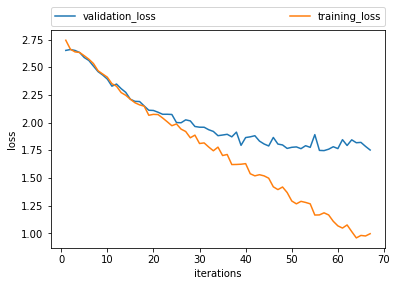

[2.6525098383426666,
 2.6607820789019265,
 2.6521451473236084,
 2.6333999037742615,
 2.5882672369480133,
 2.5617183446884155,
 2.510928690433502,
 2.4609828193982444,
 2.4303609331448874,
 2.3938761055469513,
 2.329660107692083,
 2.3488230407238007,
 2.307658165693283,
 2.273785794774691,
 2.211903606851896,
 2.1927552123864493,
 2.1909652948379517,
 2.1510278781255088,
 2.112366537253062,
 2.110370929042498,
 2.0944358309110007,
 2.0759081741174064,
 2.0761890014012656,
 2.0741485009590783,
 2.0012919157743454,
 1.9994366665681202,
 2.0256861746311188,
 2.0161946465571723,
 1.9657693306605022,
 1.9593033889929454,
 1.958920086423556,
 1.9364188859860103,
 1.9210971643527348,
 1.8827206244071324,
 1.8886588215827942,
 1.8951927522818248,
 1.8723188589016597,
 1.9149116724729538,
 1.7955756386121113,
 1.8658166825771332,
 1.8723443498214085,
 1.8823921432097752,
 1.833808993299802,
 1.8078069885571797,
 1.7899293452501297,
 1.8668452004591625,
 1.8070499400297801,
 1.7990795572598774,
 

In [55]:
train_save('both', 0, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.6787490701675414, validation_error:2.6526241655702942
Best loss improvement from inf to 2.6526241655702942 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6350699615478517, validation_error:2.633214747464215
Best loss improvement from 2.6526241655702942 to 2.633214747464215 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6116736793518065, validation_error:2.6305451922946506
Best loss improvement from 2.633214747464215 to 2.6305451922946506 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6098290491104126, validation_error:2.616587206169411
Best loss improvement from 2.6305451922946506 to 2.616587206169411 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.602794814109802, validation_error:2.593799176039519
Best loss improvement from 2.616587206169411 to 2.593799176039519 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.5575943756103516, validation_

minibatch:209, epoch:11, iteration:2599, training_error:1.3122574400901794, validation_error:1.7294354482933327
minibatch:20, epoch:12, iteration:2649, training_error:1.2695078539848328, validation_error:1.6862242839954518
Best loss improvement from 1.6930803722805448 to 1.6862242839954518 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.1916201257705687, validation_error:1.7000617009622079
minibatch:120, epoch:12, iteration:2749, training_error:1.1694054579734803, validation_error:1.7044875577644065
minibatch:170, epoch:12, iteration:2799, training_error:1.2112207639217376, validation_error:1.7166506361078333
minibatch:220, epoch:12, iteration:2849, training_error:1.156710455417633, validation_error:1.7643770420992817
minibatch:31, epoch:13, iteration:2899, training_error:1.1258911550045014, validation_error:1.6868723498450384
minibatch:81, epoch:13, iteration:2949, training_error:1.0831903386116029, validation_error:1.7347540458043416
minibatch:131, epoch:13, iter

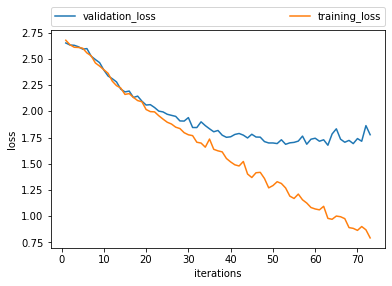

[2.6526241655702942,
 2.633214747464215,
 2.6305451922946506,
 2.616587206169411,
 2.593799176039519,
 2.5989999064692744,
 2.526687842828256,
 2.494595200927169,
 2.465006528077302,
 2.3945030018135354,
 2.3376880751715765,
 2.311752032350611,
 2.281292676925659,
 2.212695002555847,
 2.185863309436374,
 2.1941092985647694,
 2.1330653296576605,
 2.1455672537838972,
 2.0978743411876537,
 2.060738718068158,
 2.0643369842458656,
 2.036947524106061,
 2.002623447665462,
 1.9950450658798218,
 1.9726259664252952,
 1.9623333524774622,
 1.952407541098418,
 1.9090270687032629,
 1.9077619137587372,
 1.9408209588792589,
 1.8464655876159668,
 1.8458941512637668,
 1.9004615942637126,
 1.864404629777979,
 1.834045030452587,
 1.8055949211120605,
 1.8179916717388012,
 1.7730433764281097,
 1.7528827322853937,
 1.757728342656736,
 1.7802906389589663,
 1.7892384794023302,
 1.7734526528252497,
 1.7465699292995311,
 1.7818909309528492,
 1.755556795332167,
 1.7543673780229356,
 1.711942814014576,
 1.69881564

In [56]:
train_save('both', 1, 0, patience=10)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
minibatch:49, epoch:1, iteration:49, training_error:2.7098746871948243, validation_error:2.6469947497049966
Best loss improvement from inf to 2.6469947497049966 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.630077114105225, validation_error:2.6015673831657127
Best loss improvement from 2.6469947497049966 to 2.6015673831657127 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.606190004348755, validation_error:2.596997367011176
Best loss improvement from 2.6015673831657127 to 2.596997367011176 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5895384979248046, validation_error:2.576699080290618
Best loss improvement from 2.596997367011176 to 2.576699080290618 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.5590533018112183, validation_error:2.5647486757349083
Best loss improvement fro

minibatch:42, epoch:12, iteration:2649, training_error:1.3155893790721893, validation_error:1.7878203745241519
minibatch:92, epoch:12, iteration:2699, training_error:1.3391332507133484, validation_error:1.7873648780363578
minibatch:142, epoch:12, iteration:2749, training_error:1.3546079039573669, validation_error:1.761848524764732
minibatch:192, epoch:12, iteration:2799, training_error:1.2974565362930297, validation_error:1.7287892191498369
Best loss improvement from 1.7526689547079581 to 1.7287892191498369 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:1.2821357500553132, validation_error:1.8069954536579274
minibatch:55, epoch:13, iteration:2899, training_error:1.1979508662223817, validation_error:1.7924595497272633
minibatch:105, epoch:13, iteration:2949, training_error:1.2229147219657899, validation_error:1.743739472495185
minibatch:155, epoch:13, iteration:2999, training_error:1.213489009141922, validation_error:1.7702347923208166
minibatch:205, epoch:13, iterati

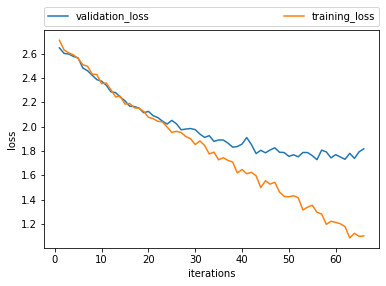

[2.6469947497049966,
 2.6015673831657127,
 2.596997367011176,
 2.576699080290618,
 2.5647486757349083,
 2.481664498647054,
 2.4596730868021646,
 2.4221043056911893,
 2.3862416214413114,
 2.373974049532855,
 2.3410820960998535,
 2.286157581541273,
 2.2794783645206027,
 2.2428566261574074,
 2.2125419952251293,
 2.1683401575794927,
 2.1652341109734996,
 2.1527888863175004,
 2.113946473156964,
 2.1254661745495267,
 2.0904256767696805,
 2.0745527611838446,
 2.045514786684955,
 2.0213301005186857,
 2.051625547585664,
 2.0231130917867026,
 1.9742637077967327,
 1.9803886810938518,
 1.9845587854032163,
 1.976023969826875,
 1.9391472383781716,
 1.9115552019189905,
 1.9261958864000108,
 1.8793157427399247,
 1.8907911600889984,
 1.8898844144962452,
 1.8648596648816709,
 1.8314433053687766,
 1.837052513051916,
 1.8569763722243133,
 1.9104703002505832,
 1.8530795971552532,
 1.7789920656769365,
 1.8059975041283503,
 1.7849139858175207,
 1.8086359545036599,
 1.8260650987978335,
 1.789933853679233,
 1.

In [57]:
train_save('both', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7255046939849854, validation_error:2.6481477242928966
Best loss improvement from inf to 2.6481477242928966 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.663788652420044, validation_error:2.6304173822756165
Best loss improvement from 2.6481477242928966 to 2.6304173822756165 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6349239778518676, validation_error:2.626060865543507
Best loss improvement from 2.6304173822756165 to 2.626060865543507 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.620558190345764, validation_error:2.605053707405373
Best loss improvement from 2.626060865543507 to 2.605053707405373 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.6046528005599976, validation_error:2.5581468034673622
Best loss improvement from 2.605053707405373 to 2.5581468034673622 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.5356246423721314, validation_

minibatch:139, epoch:11, iteration:2549, training_error:1.3818348908424378, validation_error:1.7884240415361192
minibatch:189, epoch:11, iteration:2599, training_error:1.4151259899139403, validation_error:1.7897748858840377
minibatch:239, epoch:11, iteration:2649, training_error:1.4092641925811769, validation_error:1.751384969110842
Best loss improvement from 1.7661394543117948 to 1.751384969110842 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.2595365643501282, validation_error:1.7388710313373141
Best loss improvement from 1.751384969110842 to 1.7388710313373141 in epoch 12
minibatch:98, epoch:12, iteration:2749, training_error:1.2899919354915619, validation_error:1.8681360174108435
minibatch:148, epoch:12, iteration:2799, training_error:1.2815811717510224, validation_error:1.821051730049981
minibatch:198, epoch:12, iteration:2849, training_error:1.3150083208084107, validation_error:1.7826505855277732
minibatch:7, epoch:13, iteration:2899, training_error:1.256342

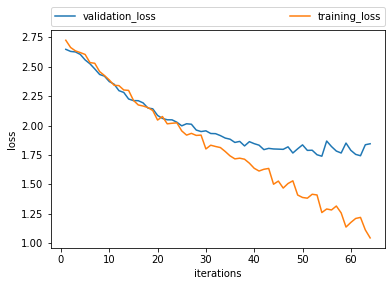

[2.6481477242928966,
 2.6304173822756165,
 2.626060865543507,
 2.605053707405373,
 2.5581468034673622,
 2.5252472824520535,
 2.481499362874914,
 2.434562056152909,
 2.420075566680343,
 2.373928290826303,
 2.3516269436588995,
 2.296633420167146,
 2.281461618564747,
 2.2257984655874745,
 2.211850563685099,
 2.2112670916098134,
 2.1925252499403776,
 2.1488487985399036,
 2.142114343466582,
 2.0856539982336537,
 2.060658476970814,
 2.0488201291472823,
 2.0482252836227417,
 2.0277956591712103,
 1.9973940098727192,
 2.014991049413328,
 2.010904064884892,
 1.9614226244114064,
 1.9487056025752314,
 1.9547915282072845,
 1.932058228386773,
 1.9306974675920274,
 1.9141748393023457,
 1.893285075823466,
 1.8836685728143763,
 1.8560497760772705,
 1.8648988803227742,
 1.8263552762843944,
 1.8626274400287204,
 1.8455885560424239,
 1.8328328088477805,
 1.7948692992881492,
 1.8055728673934937,
 1.80050708187951,
 1.799076451195611,
 1.7973249046890825,
 1.8186647450482403,
 1.7661394543117948,
 1.8020345

In [58]:
train_save('both', 3, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7143323802948, validation_error:2.6334936435406027
Best loss improvement from inf to 2.6334936435406027 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.644615535736084, validation_error:2.607601367510282
Best loss improvement from 2.6334936435406027 to 2.607601367510282 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.60248809337616, validation_error:2.583430134333097
Best loss improvement from 2.607601367510282 to 2.583430134333097 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.582052969932556, validation_error:2.541376526539142
Best loss improvement from 2.583430134333097 to 2.541376526539142 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.529790940284729, validation_error:2.464429424359248
Best loss improvement from 2.541376526539142 to 2.464429424359248 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.5036289501190185, validation_error:2.43

minibatch:47, epoch:12, iteration:2599, training_error:1.207501413822174, validation_error:1.62128588786492
Best loss improvement from 1.6311256014383757 to 1.62128588786492 in epoch 12
minibatch:97, epoch:12, iteration:2649, training_error:1.2176552069187165, validation_error:1.6336410687519953
minibatch:147, epoch:12, iteration:2699, training_error:1.1996185421943664, validation_error:1.6498747513844416
minibatch:197, epoch:12, iteration:2749, training_error:1.2062566030025481, validation_error:1.6377116029079144
minibatch:15, epoch:13, iteration:2799, training_error:1.1452658867835999, validation_error:1.712838127062871
minibatch:65, epoch:13, iteration:2849, training_error:1.1285143435001372, validation_error:1.5734060269135695
Best loss improvement from 1.62128588786492 to 1.5734060269135695 in epoch 13
minibatch:115, epoch:13, iteration:2899, training_error:1.1036256921291352, validation_error:1.6726239507014935
minibatch:165, epoch:13, iteration:2949, training_error:1.1034765648

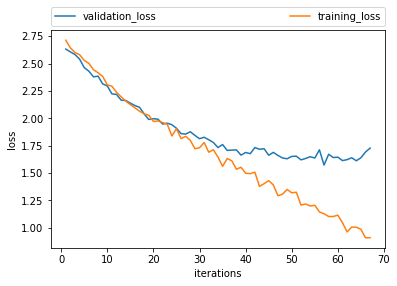

[2.6334936435406027,
 2.607601367510282,
 2.583430134333097,
 2.541376526539142,
 2.464429424359248,
 2.4316035142311683,
 2.3799238204956055,
 2.3860371846419115,
 2.3152762972391567,
 2.296540562923138,
 2.2239638291872463,
 2.2194683735187235,
 2.1666890932963443,
 2.1639338594216566,
 2.1391278138527503,
 2.1174796040241537,
 2.1013037745769205,
 2.040737523482396,
 1.9899766949506907,
 1.997362916286175,
 1.9925807485213647,
 1.948279972259815,
 1.9563603401184082,
 1.9423331664158747,
 1.909786398594196,
 1.860996636060568,
 1.856745339356936,
 1.8782180914512048,
 1.8446452067448542,
 1.8145086765289307,
 1.8276402537639325,
 1.804772069820991,
 1.7798942877696111,
 1.7334817602084234,
 1.7610747172282293,
 1.7076556086540222,
 1.710259043253385,
 1.7120629594876215,
 1.6641801870786226,
 1.6887058157187242,
 1.6775572070708642,
 1.7335847982993493,
 1.7181131289555476,
 1.7230563347156231,
 1.6634329419869642,
 1.6895990555103009,
 1.661771875161391,
 1.6384744919263399,
 1.631

In [59]:
train_save('both', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7498182249069214, validation_error:2.6797846953074136
Best loss improvement from inf to 2.6797846953074136 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6722599506378173, validation_error:2.6629719734191895
Best loss improvement from 2.6797846953074136 to 2.6629719734191895 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6523830938339232, validation_error:2.6426381270090737
Best loss improvement from 2.6629719734191895 to 2.6426381270090737 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.643610424995422, validation_error:2.6104493737220764
Best loss improvement from 2.6426381270090737 to 2.6104493737220764 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.5833402061462403, validation_error:2.5863510568936667
Best loss improvement from 2.6104493737220764 to 2.5863510568936667 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.552133712768555, vali

minibatch:135, epoch:12, iteration:2599, training_error:1.5790228509902955, validation_error:1.7778287380933762
Best loss improvement from 1.7822797447443008 to 1.7778287380933762 in epoch 12
minibatch:185, epoch:12, iteration:2649, training_error:1.615550708770752, validation_error:1.777101104458173
Best loss improvement from 1.7778287380933762 to 1.777101104458173 in epoch 12
minibatch:11, epoch:13, iteration:2699, training_error:1.5705111670494079, validation_error:1.7125869542360306
Best loss improvement from 1.777101104458173 to 1.7125869542360306 in epoch 13
minibatch:61, epoch:13, iteration:2749, training_error:1.5399052786827088, validation_error:1.7869905084371567
minibatch:111, epoch:13, iteration:2799, training_error:1.5431212592124939, validation_error:1.7397795518239338
minibatch:161, epoch:13, iteration:2849, training_error:1.509276843070984, validation_error:1.7156424323717754
minibatch:211, epoch:13, iteration:2899, training_error:1.5430465865135192, validation_error:1.

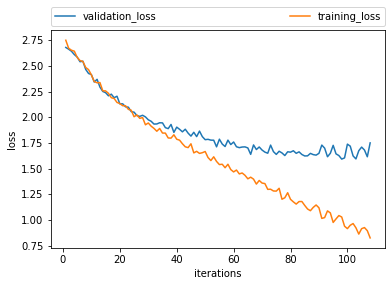

[2.6797846953074136,
 2.6629719734191895,
 2.6426381270090737,
 2.6104493737220764,
 2.5863510568936667,
 2.5408569673697152,
 2.545871506134669,
 2.466069996356964,
 2.426496058702469,
 2.4157555202643075,
 2.3430429498354592,
 2.3696101903915405,
 2.2942887345949807,
 2.251737336317698,
 2.2393930554389954,
 2.2092727422714233,
 2.2250112742185593,
 2.190619354446729,
 2.205065776904424,
 2.1307954291502633,
 2.131008103489876,
 2.1019053608179092,
 2.0983459105094275,
 2.0550186236699424,
 2.0499335577090583,
 2.0169167816638947,
 2.0089929401874542,
 2.019572233160337,
 2.0038997679948807,
 1.9758313248554866,
 1.9613862683375676,
 1.9341503133376439,
 1.9352205296357472,
 1.946911280353864,
 1.9456064452727635,
 1.8995370864868164,
 1.8897934357325237,
 1.9301767895619075,
 1.853283514579137,
 1.9041864722967148,
 1.883210375905037,
 1.8585796256860097,
 1.883967821796735,
 1.845974678794543,
 1.8170395493507385,
 1.854250098268191,
 1.812058225274086,
 1.8658107668161392,
 1.8119

In [60]:
train_save('both', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.709560041427612, validation_error:2.672027923442699
Best loss improvement from inf to 2.672027923442699 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6503834915161133, validation_error:2.645916046919646
Best loss improvement from 2.672027923442699 to 2.645916046919646 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.619818859100342, validation_error:2.642720407909817
Best loss improvement from 2.645916046919646 to 2.642720407909817 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.604221849441528, validation_error:2.62233387099372
Best loss improvement from 2.642720407909817 to 2.62233387099372 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.6006705808639525, validation_error:2.5965494049919977
Best loss improvement from 2.62233387099372 to 2.5965494049919977 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.551293344497681, validation_error:2.58

minibatch:109, epoch:11, iteration:2499, training_error:1.601177384853363, validation_error:1.7912053178857874
minibatch:159, epoch:11, iteration:2549, training_error:1.6022255969047547, validation_error:1.745987680223253
Best loss improvement from 1.7676686357568812 to 1.745987680223253 in epoch 11
minibatch:209, epoch:11, iteration:2599, training_error:1.6188920998573304, validation_error:1.7261747563326801
Best loss improvement from 1.745987680223253 to 1.7261747563326801 in epoch 11
minibatch:20, epoch:12, iteration:2649, training_error:1.5495744967460632, validation_error:1.7141390023408112
Best loss improvement from 1.7261747563326801 to 1.7141390023408112 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.5115923404693603, validation_error:1.7196071810192533
minibatch:120, epoch:12, iteration:2749, training_error:1.5463564586639404, validation_error:1.732332216368781
minibatch:170, epoch:12, iteration:2799, training_error:1.5582841563224792, validation_error:1.

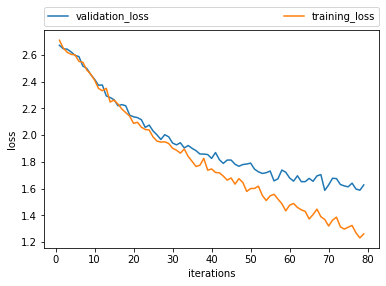

[2.672027923442699,
 2.645916046919646,
 2.642720407909817,
 2.62233387099372,
 2.5965494049919977,
 2.5873772038353815,
 2.5168110352975352,
 2.499328092292503,
 2.4540677423830384,
 2.418494047941985,
 2.373346381717258,
 2.3751232005931713,
 2.293798738055759,
 2.2814914738690413,
 2.26528822934186,
 2.2201721050121166,
 2.2285498601418956,
 2.2197899862572,
 2.149753725087201,
 2.1372723756013094,
 2.131480817441587,
 2.1155001896399037,
 2.058270984225803,
 2.0756199668954918,
 2.0315182694682368,
 2.002494079095346,
 1.9677976855525263,
 2.0036952054059065,
 1.987822241253323,
 1.9412946656898216,
 1.9276004588162456,
 1.943274908595615,
 1.9046103380344532,
 1.9227139508282696,
 1.9018323200720328,
 1.8843902702684756,
 1.8595352746822216,
 1.858733888025637,
 1.8552981306005407,
 1.826497303114997,
 1.8703615842042145,
 1.8167209139576665,
 1.7891232260951289,
 1.8142585931000885,
 1.8141079567096852,
 1.7829625253324155,
 1.7676686357568812,
 1.7806934339028817,
 1.78442813290

In [61]:
train_save('both', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.7167043399810793, validation_error:2.628493662233706
Best loss improvement from inf to 2.628493662233706 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6421036434173586, validation_error:2.6167658788186534
Best loss improvement from 2.628493662233706 to 2.6167658788186534 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6249977111816407, validation_error:2.5788936261777526
Best loss improvement from 2.6167658788186534 to 2.5788936261777526 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.58551176071167, validation_error:2.58173934618632
minibatch:12, epoch:2, iteration:249, training_error:2.5700815773010253, validation_error:2.559007750617133
Best loss improvement from 2.5788936261777526 to 2.559007750617133 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.5299601316452027, validation_error:2.5295037340234825
Best loss improvement from 2.559007750617133 to 2.5295

minibatch:229, epoch:11, iteration:2599, training_error:1.7051734447479248, validation_error:1.7756930589675903
Best loss improvement from 1.788766587222064 to 1.7756930589675903 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:1.6192944979667663, validation_error:1.769633655194883
Best loss improvement from 1.7756930589675903 to 1.769633655194883 in epoch 12
minibatch:92, epoch:12, iteration:2699, training_error:1.6207973408699035, validation_error:1.7834717432657878
minibatch:142, epoch:12, iteration:2749, training_error:1.5563036608695984, validation_error:1.744590401649475
Best loss improvement from 1.769633655194883 to 1.744590401649475 in epoch 12
minibatch:192, epoch:12, iteration:2799, training_error:1.6525673818588258, validation_error:1.7249973659162168
Best loss improvement from 1.744590401649475 to 1.7249973659162168 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:1.546886568069458, validation_error:1.7566159124727603
minibatch:55, epoch:

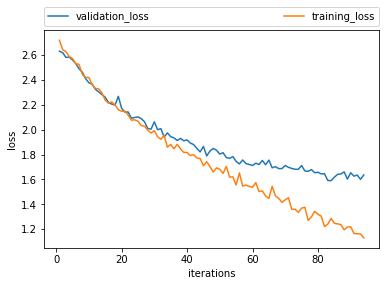

[2.628493662233706,
 2.6167658788186534,
 2.5788936261777526,
 2.58173934618632,
 2.559007750617133,
 2.5295037340234825,
 2.4872723243854664,
 2.459998042495162,
 2.4089665324599654,
 2.375571930849994,
 2.3652799041182906,
 2.323192243222837,
 2.3028592930899725,
 2.2807654716350414,
 2.2590543075844094,
 2.2177722498222634,
 2.2042796744240656,
 2.1971515770311707,
 2.2669483688142567,
 2.1713947190178766,
 2.139866820088139,
 2.141411436928643,
 2.090783445923417,
 2.097382757398817,
 2.1014787356058755,
 2.088315102789137,
 2.0629034307267933,
 2.0087861484951444,
 2.0034288741924144,
 2.062343226538764,
 1.9991448985205755,
 2.007983265099702,
 1.9403992273189403,
 1.9739395865687617,
 1.94333608062179,
 1.9336219054681283,
 1.9123670392566257,
 1.9292933764281097,
 1.9106426459771615,
 1.917483064863417,
 1.8921404503009938,
 1.8800637280499493,
 1.8491002012182165,
 1.8213022461643926,
 1.8650583249551278,
 1.788766587222064,
 1.8282589426747076,
 1.8487154907650418,
 1.8342778

In [62]:
train_save('both', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.745104179382324, validation_error:2.6463542690983526
Best loss improvement from inf to 2.6463542690983526 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6537289810180664, validation_error:2.6311322671395763
Best loss improvement from 2.6463542690983526 to 2.6311322671395763 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.630692510604858, validation_error:2.6189478503333197
Best loss improvement from 2.6311322671395763 to 2.6189478503333197 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6105051326751707, validation_error:2.5757750228599265
Best loss improvement from 2.6189478503333197 to 2.5757750228599265 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.5747651290893554, validation_error:2.5393752610241926
Best loss improvement from 2.5757750228599265 to 2.5393752610241926 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.5450828504562377, valid

minibatch:39, epoch:11, iteration:2449, training_error:1.6575217151641846, validation_error:1.812545202396534
minibatch:89, epoch:11, iteration:2499, training_error:1.671756672859192, validation_error:1.7941030263900757
Best loss improvement from 1.8033145312909726 to 1.7941030263900757 in epoch 11
minibatch:139, epoch:11, iteration:2549, training_error:1.6463873386383057, validation_error:1.8417872278778642
minibatch:189, epoch:11, iteration:2599, training_error:1.6459980535507202, validation_error:1.8145012458165486
minibatch:239, epoch:11, iteration:2649, training_error:1.6400159740447997, validation_error:1.8193993656723588
minibatch:48, epoch:12, iteration:2699, training_error:1.6123323082923888, validation_error:1.793685996973956
Best loss improvement from 1.7941030263900757 to 1.793685996973956 in epoch 12
minibatch:98, epoch:12, iteration:2749, training_error:1.617424795627594, validation_error:1.8114862044652302
minibatch:148, epoch:12, iteration:2799, training_error:1.5993099

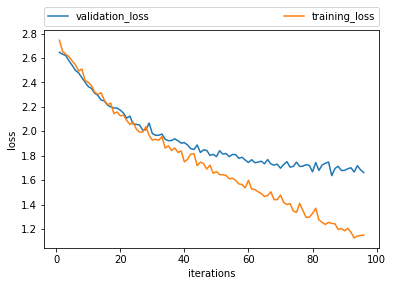

[2.6463542690983526,
 2.6311322671395763,
 2.6189478503333197,
 2.5757750228599265,
 2.5393752610241926,
 2.499077143492522,
 2.4782044181117304,
 2.4391899462099427,
 2.4029405381944446,
 2.366680286548756,
 2.3513464309551098,
 2.3127199897059687,
 2.294113521222715,
 2.2562526067097983,
 2.249718568943165,
 2.214297789114493,
 2.2011670801374645,
 2.1916625985392817,
 2.190507690111796,
 2.1738132061781705,
 2.14969594390304,
 2.108633867016545,
 2.125054708233586,
 2.059672139309071,
 2.0576525617528847,
 2.052185681131151,
 2.010136944276315,
 2.0135893159442477,
 2.068274153603448,
 1.982810338338216,
 1.9686142029585663,
 1.9685811908156783,
 1.9778717270603887,
 1.9365855322943792,
 1.9237817172650937,
 1.925582832760281,
 1.9395524660746257,
 1.9232561102619878,
 1.9041605039879128,
 1.9080711779771027,
 1.8888462958512482,
 1.8586209615071614,
 1.8523048648127802,
 1.8886977743219446,
 1.8277103635999892,
 1.8492209778891668,
 1.84444436762068,
 1.8033145312909726,
 1.8125452

In [63]:
train_save('both', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.714821424484253, validation_error:2.6470973583368154
Best loss improvement from inf to 2.6470973583368154 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.629254364967346, validation_error:2.624389437528757
Best loss improvement from 2.6470973583368154 to 2.624389437528757 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.632232623100281, validation_error:2.602625929392301
Best loss improvement from 2.624389437528757 to 2.602625929392301 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.594435176849365, validation_error:2.5857550547673154
Best loss improvement from 2.602625929392301 to 2.5857550547673154 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.5881103706359863, validation_error:2.528899614627545
Best loss improvement from 2.5857550547673154 to 2.528899614627545 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.5669796895980834, validation_err

minibatch:229, epoch:11, iteration:2549, training_error:1.5570649266242982, validation_error:1.6679989328751197
Best loss improvement from 1.6776059590853178 to 1.6679989328751197 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:1.5420067763328553, validation_error:1.6641460382021391
Best loss improvement from 1.6679989328751197 to 1.6641460382021391 in epoch 12
minibatch:97, epoch:12, iteration:2649, training_error:1.5218863105773925, validation_error:1.6706900183971112
minibatch:147, epoch:12, iteration:2699, training_error:1.5256064176559447, validation_error:1.6360599490312429
Best loss improvement from 1.6641460382021391 to 1.6360599490312429 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:1.4896081805229187, validation_error:1.6665157217245836
minibatch:15, epoch:13, iteration:2799, training_error:1.4573696446418762, validation_error:1.6295817815340483
Best loss improvement from 1.6360599490312429 to 1.6295817815340483 in epoch 13
minibatch:6

minibatch:181, epoch:25, iteration:5749, training_error:0.8498135042190552, validation_error:1.5430251451639028
minibatch:231, epoch:25, iteration:5799, training_error:0.8126771891117096, validation_error:1.555696469086867
minibatch:49, epoch:26, iteration:5849, training_error:0.7552206528186798, validation_error:1.5649581734950726
minibatch:99, epoch:26, iteration:5899, training_error:0.7389784586429596, validation_error:1.6158519799892719
minibatch:149, epoch:26, iteration:5949, training_error:0.7472971671819687, validation_error:1.5464692986928499
minibatch:199, epoch:26, iteration:5999, training_error:0.8065253156423569, validation_error:1.5693684312013478
minibatch:17, epoch:27, iteration:6049, training_error:0.7943079751729966, validation_error:1.6129129483149602
minibatch:67, epoch:27, iteration:6099, training_error:0.7471341353654861, validation_error:1.5935488939285278
Patience ran out at 6099. Ending training


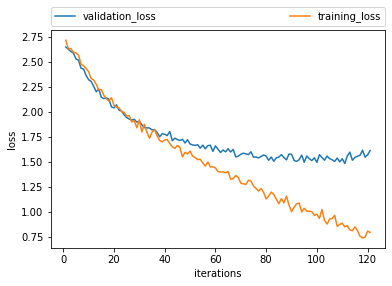

[2.6470973583368154,
 2.624389437528757,
 2.602625929392301,
 2.5857550547673154,
 2.528899614627545,
 2.5159922563112698,
 2.4355776401666493,
 2.4273968659914456,
 2.3634126553168664,
 2.320446151953477,
 2.302726984024048,
 2.254424516971295,
 2.198927076963278,
 2.2277920704621534,
 2.1465261532710147,
 2.1311491223481984,
 2.1385967823175283,
 2.1260159474152784,
 2.04833199427678,
 2.039028960924882,
 2.069454183945289,
 2.0152383538392873,
 2.0073358233158407,
 1.9692131968644948,
 1.9418628765986516,
 1.927353927722344,
 1.916994837614206,
 1.9242446743524992,
 1.8967793400471027,
 1.905997647688939,
 1.8690514472814708,
 1.8414941430091858,
 1.8391587550823505,
 1.8371691703796387,
 1.8191989935361421,
 1.8218110570540795,
 1.792400910304143,
 1.7500168589445262,
 1.7796982526779175,
 1.7745055647996755,
 1.762259813455435,
 1.802440106868744,
 1.710008754180028,
 1.7362089523902307,
 1.7220140878970807,
 1.7129743374311006,
 1.7248015220348651,
 1.6877798850719745,
 1.7207296

In [64]:
train_save('both', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.7533326292037965, validation_error:2.6824874778588614
Best loss improvement from inf to 2.6824874778588614 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.662141356468201, validation_error:2.6508110761642456
Best loss improvement from 2.6824874778588614 to 2.6508110761642456 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6496339416503907, validation_error:2.670712500810623
minibatch:199, epoch:1, iteration:199, training_error:2.6413099813461303, validation_error:2.6384043296178183
Best loss improvement from 2.6508110761642456 to 2.6384043296178183 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.6147311973571776, validation_error:2.5851429800192514
Best loss improvement from 2.6384043296178183 to 2.5851429800192514 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.5733599948883055, validation_error:2.5517067313194275
Best loss improvement from 2.5851429800192514 t

minibatch:85, epoch:12, iteration:2549, training_error:1.8089071965217591, validation_error:1.8546525935331981
Best loss improvement from 1.8693999002377193 to 1.8546525935331981 in epoch 12
minibatch:135, epoch:12, iteration:2599, training_error:1.8074352979660033, validation_error:1.8519796629746754
Best loss improvement from 1.8546525935331981 to 1.8519796629746754 in epoch 12
minibatch:185, epoch:12, iteration:2649, training_error:1.8388312029838563, validation_error:1.8173320591449738
Best loss improvement from 1.8519796629746754 to 1.8173320591449738 in epoch 12
minibatch:11, epoch:13, iteration:2699, training_error:1.7907794690132142, validation_error:1.8275564759969711
minibatch:61, epoch:13, iteration:2749, training_error:1.8291071200370788, validation_error:1.8168529520432155
Best loss improvement from 1.8173320591449738 to 1.8168529520432155 in epoch 13
minibatch:111, epoch:13, iteration:2799, training_error:1.7741268348693848, validation_error:1.7830343047777812
Best loss i

minibatch:223, epoch:25, iteration:5599, training_error:1.3194620168209077, validation_error:1.5715750306844711
minibatch:49, epoch:26, iteration:5649, training_error:1.2767144644260406, validation_error:1.627468133966128
minibatch:99, epoch:26, iteration:5699, training_error:1.2881975364685059, validation_error:1.597059354186058
minibatch:149, epoch:26, iteration:5749, training_error:1.328001593351364, validation_error:1.505839467048645
Best loss improvement from 1.5551616152127583 to 1.505839467048645 in epoch 26
minibatch:199, epoch:26, iteration:5799, training_error:1.2711465811729432, validation_error:1.5892015943924587
minibatch:25, epoch:27, iteration:5849, training_error:1.285777132511139, validation_error:1.5724484423796337
minibatch:75, epoch:27, iteration:5899, training_error:1.2422939217090607, validation_error:1.5465136766433716
minibatch:125, epoch:27, iteration:5949, training_error:1.2865005576610564, validation_error:1.576528360446294
minibatch:175, epoch:27, iteration:

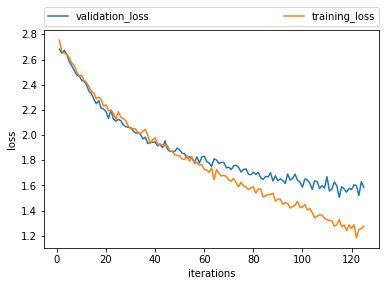

[2.6824874778588614,
 2.6508110761642456,
 2.670712500810623,
 2.6384043296178183,
 2.5851429800192514,
 2.5517067313194275,
 2.514737864335378,
 2.478690981864929,
 2.472382535537084,
 2.4367463290691376,
 2.4282570679982505,
 2.4014207124710083,
 2.3503377040227256,
 2.331121027469635,
 2.285998890797297,
 2.2485777537027993,
 2.273986597855886,
 2.2134309311707816,
 2.206668257713318,
 2.1858523786067963,
 2.1321553538242974,
 2.1988548586765924,
 2.127890388170878,
 2.1100584864616394,
 2.1245705584685006,
 2.1149183958768845,
 2.080529883503914,
 2.0672981242338815,
 2.061415175596873,
 2.0584602703650794,
 2.0358084241549173,
 2.016538838545481,
 2.0166811446348825,
 2.007166420420011,
 1.968617707490921,
 1.9835112690925598,
 1.9324214508136113,
 1.940863276521365,
 1.9423131744066875,
 1.9464575697978337,
 1.9140719423691432,
 1.9289771964152653,
 1.8997126271327336,
 1.9539381663004558,
 1.8883070747057598,
 1.8704525977373123,
 1.8715355445941289,
 1.8693999002377193,
 1.8968

In [65]:
train_save('both', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.7223655652999876, validation_error:2.6584814654456244
Best loss improvement from inf to 2.6584814654456244 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6513708448410034, validation_error:2.642555598859434
Best loss improvement from 2.6584814654456244 to 2.642555598859434 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.630258069038391, validation_error:2.630949921078152
Best loss improvement from 2.642555598859434 to 2.630949921078152 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5961153364181517, validation_error:2.6323423738832825
minibatch:10, epoch:2, iteration:249, training_error:2.584025263786316, validation_error:2.6089671364536993
Best loss improvement from 2.630949921078152 to 2.6089671364536993 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.5737649822235107, validation_error:2.581233828156083
Best loss improvement from 2.6089671364536993 to 2.581

minibatch:159, epoch:11, iteration:2549, training_error:1.7765764474868775, validation_error:1.7936275491008051
minibatch:209, epoch:11, iteration:2599, training_error:1.7416139817237855, validation_error:1.7887184045932911
minibatch:20, epoch:12, iteration:2649, training_error:1.778913094997406, validation_error:1.8552839711860374
minibatch:70, epoch:12, iteration:2699, training_error:1.7690225219726563, validation_error:1.7877555820677016
minibatch:120, epoch:12, iteration:2749, training_error:1.674459638595581, validation_error:1.7830860879686143
Best loss improvement from 1.787068040282638 to 1.7830860879686143 in epoch 12
minibatch:170, epoch:12, iteration:2799, training_error:1.7112563848495483, validation_error:1.761682881249322
Best loss improvement from 1.7830860879686143 to 1.761682881249322 in epoch 12
minibatch:220, epoch:12, iteration:2849, training_error:1.7026467084884644, validation_error:1.7196967469321356
Best loss improvement from 1.761682881249322 to 1.7196967469321

minibatch:152, epoch:24, iteration:5649, training_error:1.279946517944336, validation_error:1.5041957784582067
Best loss improvement from 1.5117084582646687 to 1.5041957784582067 in epoch 24
minibatch:202, epoch:24, iteration:5699, training_error:1.2427777278423309, validation_error:1.530607541402181
minibatch:13, epoch:25, iteration:5749, training_error:1.2576751434803009, validation_error:1.5531038443247478
minibatch:63, epoch:25, iteration:5799, training_error:1.2416011500358581, validation_error:1.486850177800214
Best loss improvement from 1.5041957784582067 to 1.486850177800214 in epoch 25
minibatch:113, epoch:25, iteration:5849, training_error:1.2424098682403564, validation_error:1.5414017306433783
minibatch:163, epoch:25, iteration:5899, training_error:1.2899147033691407, validation_error:1.5154691448918096
minibatch:213, epoch:25, iteration:5949, training_error:1.20908123254776, validation_error:1.5065559016333685
minibatch:24, epoch:26, iteration:5999, training_error:1.2532099

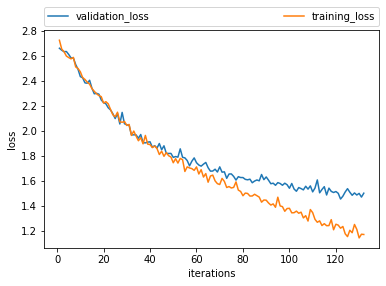

[2.6584814654456244,
 2.642555598859434,
 2.630949921078152,
 2.6323423738832825,
 2.6089671364536993,
 2.581233828156083,
 2.580922488813047,
 2.528623695726748,
 2.4906978695480912,
 2.4322918079517506,
 2.422307915157742,
 2.3819480030624955,
 2.3792253070407443,
 2.4027576093320495,
 2.338804571716874,
 2.294841444050824,
 2.298543960959823,
 2.2915351346687034,
 2.245540005189401,
 2.2249317699008517,
 2.2147724584296897,
 2.1832475353170326,
 2.16582868275819,
 2.135620426248621,
 2.0970564639126814,
 2.136654535929362,
 2.0537149243884616,
 2.14615437719557,
 2.055507920406483,
 2.0470726136808044,
 2.0429948700798883,
 1.9663026995129056,
 1.9671861154061776,
 1.9667658187724926,
 1.9399327834447224,
 1.969653186974702,
 1.9043640516422413,
 1.9026675974881206,
 1.9086949825286865,
 1.9115699662102594,
 1.8682196140289307,
 1.8806990252600775,
 1.8614061717633847,
 1.897821033442462,
 1.8475036797700104,
 1.879477403782032,
 1.8192037299827293,
 1.8182881231661197,
 1.818793985

In [66]:
train_save('both', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.7142570877075194, validation_error:2.6334039900037975
Best loss improvement from inf to 2.6334039900037975 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.619330658912659, validation_error:2.605140544750072
Best loss improvement from 2.6334039900037975 to 2.605140544750072 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.629153804779053, validation_error:2.604335149129232
Best loss improvement from 2.605140544750072 to 2.604335149129232 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.573011417388916, validation_error:2.572160941583139
Best loss improvement from 2.604335149129232 to 2.572160941583139 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.5684176158905028, validation_error:2.5493354973969637
Best loss improvement from 2.572160941583139 to 2.5493354973969637 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.5377137517929076, validation_err

minibatch:42, epoch:12, iteration:2649, training_error:1.7791843008995056, validation_error:1.8126154431590327
Best loss improvement from 1.8222861687342327 to 1.8126154431590327 in epoch 12
minibatch:92, epoch:12, iteration:2699, training_error:1.7937707781791687, validation_error:1.7980209721459284
Best loss improvement from 1.8126154431590327 to 1.7980209721459284 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.7562683892250062, validation_error:1.7949448691474066
Best loss improvement from 1.7980209721459284 to 1.7949448691474066 in epoch 12
minibatch:192, epoch:12, iteration:2799, training_error:1.7726114082336426, validation_error:1.7890242867999606
Best loss improvement from 1.7949448691474066 to 1.7890242867999606 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:1.735416920185089, validation_error:1.8086429966820612
minibatch:55, epoch:13, iteration:2899, training_error:1.7219979691505432, validation_error:1.8255445648122717
minibatch:105,

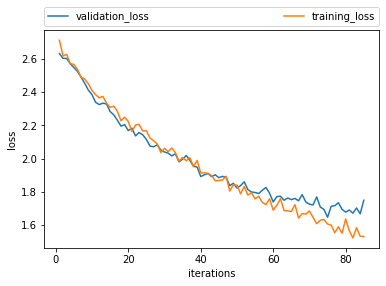

[2.6334039900037975,
 2.605140544750072,
 2.604335149129232,
 2.572160941583139,
 2.5493354973969637,
 2.525707862995289,
 2.4902090231577554,
 2.453777931354664,
 2.4124958515167236,
 2.385446310043335,
 2.339346338201452,
 2.32574815220303,
 2.3344561435558178,
 2.3294246991475425,
 2.2836471222065113,
 2.2634806986208313,
 2.2310666508144803,
 2.195600986480713,
 2.2050352273163973,
 2.1690658816584834,
 2.1836865743001304,
 2.1367697053485446,
 2.1572461702205517,
 2.1432890318058155,
 2.11520657715974,
 2.0751424453876637,
 2.0710292524761624,
 2.0828778081470065,
 2.05065060544897,
 2.0394887129465737,
 2.0326555172602334,
 2.016017436981201,
 2.0284534913522227,
 1.9804404267558344,
 1.9962218911559493,
 2.0184517480708934,
 1.988905014815154,
 1.953139102017438,
 1.9488822133452803,
 1.8911351009651467,
 1.9019311710640237,
 1.909319833472923,
 1.8907948820679277,
 1.9018478746767398,
 1.8844802467911332,
 1.8922372040925202,
 1.8880179634800665,
 1.8359709139223452,
 1.8506622

In [67]:
train_save('both', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.7144695043563845, validation_error:2.654381345819544
Best loss improvement from inf to 2.654381345819544 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.671723804473877, validation_error:2.6129384570651584
Best loss improvement from 2.654381345819544 to 2.6129384570651584 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.641019763946533, validation_error:2.6154136216198958
minibatch:199, epoch:1, iteration:199, training_error:2.629880542755127, validation_error:2.589579493911178
Best loss improvement from 2.6129384570651584 to 2.589579493911178 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.562844982147217, validation_error:2.5529261695014105
Best loss improvement from 2.589579493911178 to 2.5529261695014105 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.5636551094055178, validation_error:2.523248345763595
Best loss improvement from 2.5529261695014105 to 2.523248

minibatch:139, epoch:11, iteration:2549, training_error:1.812008204460144, validation_error:1.8393931830370869
Best loss improvement from 1.847445461485121 to 1.8393931830370869 in epoch 11
minibatch:189, epoch:11, iteration:2599, training_error:1.8277005076408386, validation_error:1.8612000191653217
minibatch:239, epoch:11, iteration:2649, training_error:1.8251848483085633, validation_error:1.8342206301512542
Best loss improvement from 1.8393931830370869 to 1.8342206301512542 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.764511399269104, validation_error:1.8163405700966164
Best loss improvement from 1.8342206301512542 to 1.8163405700966164 in epoch 12
minibatch:98, epoch:12, iteration:2749, training_error:1.779720928668976, validation_error:1.7978826231426663
Best loss improvement from 1.8163405700966164 to 1.7978826231426663 in epoch 12
minibatch:148, epoch:12, iteration:2799, training_error:1.800344202518463, validation_error:1.8346299904364127
minibatch:198, 

minibatch:197, epoch:23, iteration:5499, training_error:1.3458434009552003, validation_error:1.5904425470917314
minibatch:6, epoch:24, iteration:5549, training_error:1.3465295219421387, validation_error:1.611546759252195
minibatch:56, epoch:24, iteration:5599, training_error:1.2668467330932618, validation_error:1.609174997718246
minibatch:106, epoch:24, iteration:5649, training_error:1.3281243312358857, validation_error:1.6267147108360573
minibatch:156, epoch:24, iteration:5699, training_error:1.3528352928161622, validation_error:1.5480358379858512
Best loss improvement from 1.5876310445644237 to 1.5480358379858512 in epoch 24
minibatch:206, epoch:24, iteration:5749, training_error:1.3218486905097961, validation_error:1.6176599661509197
minibatch:15, epoch:25, iteration:5799, training_error:1.3071246480941772, validation_error:1.6257287396325006
minibatch:65, epoch:25, iteration:5849, training_error:1.2416497707366942, validation_error:1.6036035926253707
minibatch:115, epoch:25, iterat

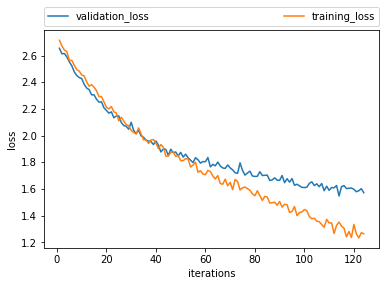

[2.654381345819544,
 2.6129384570651584,
 2.6154136216198958,
 2.589579493911178,
 2.5529261695014105,
 2.523248345763595,
 2.4775875497747353,
 2.450340844966747,
 2.4348841508229575,
 2.4277618372881853,
 2.384588612450494,
 2.356590323978,
 2.3450239057894104,
 2.305950023509838,
 2.3054684179800526,
 2.272294697938142,
 2.2506210450772888,
 2.2530832202346236,
 2.208083011485912,
 2.1887172990375094,
 2.168327313882333,
 2.1779539673416703,
 2.134015189276801,
 2.147116669902095,
 2.147552556461758,
 2.0984232160780163,
 2.075671354929606,
 2.0697397744214094,
 2.0479811606583773,
 2.100023048895377,
 2.0388432520407216,
 2.0146644115448,
 2.0407010405151933,
 1.9986280732684665,
 1.9873682878635548,
 1.9659852628354673,
 1.959838902508771,
 1.9552606962345265,
 1.9335094778626054,
 1.9599418331075598,
 1.929395079612732,
 1.8777785036298964,
 1.9007394269660667,
 1.8972652046768754,
 1.852144020575064,
 1.8981612081880923,
 1.8725932439168294,
 1.8775604610089902,
 1.8474454614851

In [68]:
train_save('both', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.723479919433594, validation_error:2.633334572498615
Best loss improvement from inf to 2.633334572498615 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6441567373275756, validation_error:2.6118137653057394
Best loss improvement from 2.633334572498615 to 2.6118137653057394 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6099825572967528, validation_error:2.5967360826639028
Best loss improvement from 2.6118137653057394 to 2.5967360826639028 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.606957130432129, validation_error:2.5743639835944543
Best loss improvement from 2.5967360826639028 to 2.5743639835944543 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.5629662227630616, validation_error:2.5404589909773607
Best loss improvement from 2.5743639835944543 to 2.5404589909773607 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.547960648536682, validati

minibatch:229, epoch:11, iteration:2549, training_error:1.7059692001342774, validation_error:1.7213263695056622
minibatch:47, epoch:12, iteration:2599, training_error:1.6981360697746277, validation_error:1.690477728843689
Best loss improvement from 1.7062980761894813 to 1.690477728843689 in epoch 12
minibatch:97, epoch:12, iteration:2649, training_error:1.6753739500045777, validation_error:1.7149748435387244
minibatch:147, epoch:12, iteration:2699, training_error:1.725223412513733, validation_error:1.6788818469414344
Best loss improvement from 1.690477728843689 to 1.6788818469414344 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:1.7005848956108094, validation_error:1.689119352744176
minibatch:15, epoch:13, iteration:2799, training_error:1.6746256637573242, validation_error:1.6652554732102613
Best loss improvement from 1.6788818469414344 to 1.6652554732102613 in epoch 13
minibatch:65, epoch:13, iteration:2849, training_error:1.658071825504303, validation_error:1.674

minibatch:81, epoch:25, iteration:5649, training_error:1.2035639131069182, validation_error:1.4950874264423664
minibatch:131, epoch:25, iteration:5699, training_error:1.17652263879776, validation_error:1.4538588982362013
minibatch:181, epoch:25, iteration:5749, training_error:1.2464115524291992, validation_error:1.4496435247934782
minibatch:231, epoch:25, iteration:5799, training_error:1.2611303675174712, validation_error:1.409018759544079
Best loss improvement from 1.4302512269753676 to 1.409018759544079 in epoch 25
minibatch:49, epoch:26, iteration:5849, training_error:1.1978196978569031, validation_error:1.4270415902137756
minibatch:99, epoch:26, iteration:5899, training_error:1.1813067185878754, validation_error:1.4261110379145696
minibatch:149, epoch:26, iteration:5949, training_error:1.207794679403305, validation_error:1.4448413986426134
minibatch:199, epoch:26, iteration:5999, training_error:1.2156077349185943, validation_error:1.452161784355457
minibatch:17, epoch:27, iteration

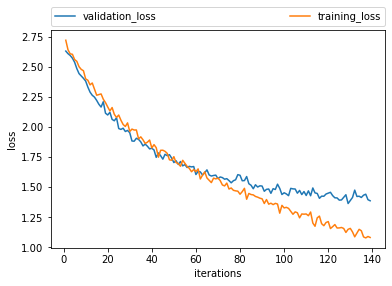

[2.633334572498615,
 2.6118137653057394,
 2.5967360826639028,
 2.5743639835944543,
 2.5404589909773607,
 2.4877860729510965,
 2.446182654454158,
 2.427105876115652,
 2.406856509355398,
 2.3841660848030677,
 2.334044649050786,
 2.2918932804694543,
 2.2657157457791843,
 2.250662922859192,
 2.2231019827035756,
 2.1911423894075246,
 2.167755099443289,
 2.212007536337926,
 2.116818313415234,
 2.1020583510398865,
 2.124414948316721,
 2.0652255370066714,
 2.0538150438895593,
 2.079095881718856,
 1.9891192362858698,
 1.982065145785992,
 1.9920586026631868,
 1.9645153971818776,
 1.9735351846768305,
 1.9544864847109868,
 1.8856474940593426,
 1.8837505349746118,
 1.9084117366717412,
 1.8986788071118867,
 1.8781780279599702,
 1.8447402165486262,
 1.8596937106205866,
 1.8423630916155302,
 1.8201435850216792,
 1.825015352322505,
 1.8108361134162316,
 1.7496036749619703,
 1.786534281877371,
 1.7633041510215173,
 1.7344737282166114,
 1.7751655349364648,
 1.7635316390257616,
 1.7719069077418401,
 1.743

In [69]:
train_save('both', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.285810022354126, validation_error:2.092788054392888
Best loss improvement from inf to 2.092788054392888 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.02505836725235, validation_error:2.0360465049743652
Best loss improvement from 2.092788054392888 to 2.0360465049743652 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.003467037677765, validation_error:1.9981728929739733
Best loss improvement from 2.0360465049743652 to 1.9981728929739733 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.986432740688324, validation_error:1.993153480383066
Best loss improvement from 1.9981728929739733 to 1.993153480383066 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.964935040473938, validation_error:1.9873107396639311
Best loss improvement from 1.993153480383066 to 1.9873107396639311 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.9439919662475587, validation_err

minibatch:42, epoch:12, iteration:2649, training_error:1.0752250754833221, validation_error:1.3868240805772634
minibatch:92, epoch:12, iteration:2699, training_error:1.0551783001422883, validation_error:1.463836248104389
minibatch:142, epoch:12, iteration:2749, training_error:1.0335911798477173, validation_error:1.3547281760435839
minibatch:192, epoch:12, iteration:2799, training_error:1.0492542695999145, validation_error:1.3697149203373835
minibatch:5, epoch:13, iteration:2849, training_error:1.0144644832611085, validation_error:1.3338965544333825
Best loss improvement from 1.3470011628591096 to 1.3338965544333825 in epoch 13
minibatch:55, epoch:13, iteration:2899, training_error:0.9281258106231689, validation_error:1.3420581771777227
minibatch:105, epoch:13, iteration:2949, training_error:0.9594904589653015, validation_error:1.3759423173390901
minibatch:155, epoch:13, iteration:2999, training_error:0.978833622932434, validation_error:1.3456286627512712
minibatch:205, epoch:13, iterat

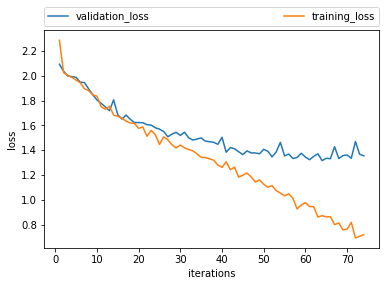

[2.092788054392888,
 2.0360465049743652,
 1.9981728929739733,
 1.993153480383066,
 1.9873107396639311,
 1.947050970334273,
 1.9457338452339172,
 1.8948267927536597,
 1.8472340198663564,
 1.8047730922698975,
 1.778327437547537,
 1.7494376668563256,
 1.718178900388571,
 1.8061333894729614,
 1.686081432379209,
 1.6517505141404958,
 1.6832898992758532,
 1.6495370956567617,
 1.623053564475133,
 1.6230729589095483,
 1.6221096423956065,
 1.6061253960315998,
 1.602794179549584,
 1.5816161128190847,
 1.5702001131497896,
 1.5515718184984648,
 1.508933282815493,
 1.5300526710656972,
 1.5450392961502075,
 1.5196071725625258,
 1.5454843227679913,
 1.5007327061433058,
 1.4824377344204829,
 1.4907569931103632,
 1.4992639743364775,
 1.473843446144691,
 1.4694888224968543,
 1.464140309737279,
 1.4480483119304364,
 1.504686373930711,
 1.3845846056938171,
 1.4219867632939265,
 1.4119955117885883,
 1.3882479071617126,
 1.3652790418038,
 1.3950215669778676,
 1.3790550461182227,
 1.3784388899803162,
 1.3720

In [70]:
train_save('age', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.2404813075065615, validation_error:2.0204313048000992
Best loss improvement from inf to 2.0204313048000992 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9770953154563904, validation_error:1.9776751666233456
Best loss improvement from 2.0204313048000992 to 1.9776751666233456 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.949945502281189, validation_error:1.9650080861716435
Best loss improvement from 1.9776751666233456 to 1.9650080861716435 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9597572350502015, validation_error:1.967876491875484
minibatch:249, epoch:1, iteration:249, training_error:1.923989133834839, validation_error:1.926825025985981
Best loss improvement from 1.9650080861716435 to 1.926825025985981 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.9071302556991576, validation_error:1.9076212315723813
Best loss improvement from 1.926825025985981 to 1

minibatch:169, epoch:11, iteration:2749, training_error:1.0866964256763458, validation_error:1.2946615527416099
minibatch:219, epoch:11, iteration:2799, training_error:1.0814376199245452, validation_error:1.2915347855666588
minibatch:11, epoch:12, iteration:2849, training_error:1.065537039041519, validation_error:1.27145830927224
Best loss improvement from 1.2766591392714401 to 1.27145830927224 in epoch 12
minibatch:61, epoch:12, iteration:2899, training_error:1.00037930727005, validation_error:1.2910412899379073
minibatch:111, epoch:12, iteration:2949, training_error:0.9956455063819886, validation_error:1.2646464253294056
Best loss improvement from 1.27145830927224 to 1.2646464253294056 in epoch 12
minibatch:161, epoch:12, iteration:2999, training_error:1.0203106117248535, validation_error:1.2711187847729386
minibatch:211, epoch:12, iteration:3049, training_error:1.0033100402355195, validation_error:1.2768685077798778
minibatch:3, epoch:13, iteration:3099, training_error:1.01695819497

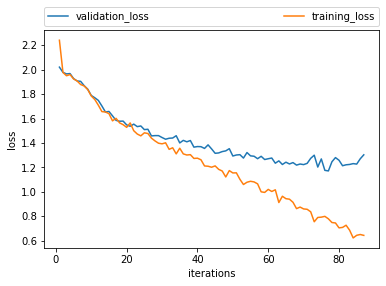

[2.0204313048000992,
 1.9776751666233456,
 1.9650080861716435,
 1.967876491875484,
 1.926825025985981,
 1.9076212315723813,
 1.9041344790623105,
 1.8684731228598233,
 1.8403031579379379,
 1.788683245921957,
 1.769846353037604,
 1.748361299777853,
 1.7028166631172443,
 1.6536228286808934,
 1.6579967819411179,
 1.6218883909028152,
 1.585024439055344,
 1.577937126159668,
 1.579012077430199,
 1.547973661587156,
 1.5368133248953983,
 1.5542190280453911,
 1.5337994221983284,
 1.5393638117560025,
 1.5094307291096654,
 1.5122643873609345,
 1.4579400358528927,
 1.4603023487946083,
 1.4603085558989952,
 1.4447275770121608,
 1.430737721508947,
 1.4387687403580238,
 1.4405877014686321,
 1.4594444468103607,
 1.4004015100413356,
 1.4213627946787868,
 1.409637714254445,
 1.4200453306066578,
 1.3660104192536453,
 1.370798764557674,
 1.3696728657031882,
 1.3554050552433934,
 1.3845545628975178,
 1.3514540483211648,
 1.315619106950431,
 1.3185955121599395,
 1.3296138788091725,
 1.3354592569943131,
 1.35

In [71]:
train_save('age', 1, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.2616971635818484, validation_error:2.0024686435173296
Best loss improvement from inf to 2.0024686435173296 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9674537658691407, validation_error:1.983986344830743
Best loss improvement from 2.0024686435173296 to 1.983986344830743 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9578202629089356, validation_error:1.9462919769615963
Best loss improvement from 1.983986344830743 to 1.9462919769615963 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9618342661857604, validation_error:1.9361856189267388
Best loss improvement from 1.9462919769615963 to 1.9361856189267388 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.942332227230072, validation_error:1.9212575822040951
Best loss improvement from 1.9361856189267388 to 1.9212575822040951 in epoch 1
minibatch:45, epoch:2, iteration:299, training_error:1.9154862356185913, valid

minibatch:59, epoch:11, iteration:2599, training_error:1.1412548851966857, validation_error:1.2789153436134602
Best loss improvement from 1.29948012582187 to 1.2789153436134602 in epoch 11
minibatch:109, epoch:11, iteration:2649, training_error:1.0978492438793181, validation_error:1.2993999061913326
minibatch:159, epoch:11, iteration:2699, training_error:1.1304331123828888, validation_error:1.2671704559490597
Best loss improvement from 1.2789153436134602 to 1.2671704559490597 in epoch 11
minibatch:209, epoch:11, iteration:2749, training_error:1.120398951768875, validation_error:1.2630610733196652
Best loss improvement from 1.2671704559490597 to 1.2630610733196652 in epoch 11
minibatch:5, epoch:12, iteration:2799, training_error:1.1618711030483246, validation_error:1.349020999053429
minibatch:55, epoch:12, iteration:2849, training_error:1.0366554045677185, validation_error:1.2936055002541378
minibatch:105, epoch:12, iteration:2899, training_error:1.0706977331638337, validation_error:1.2

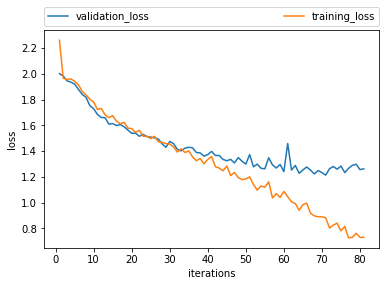

[2.0024686435173296,
 1.983986344830743,
 1.9462919769615963,
 1.9361856189267388,
 1.9212575822040951,
 1.8800479666940098,
 1.8403906493351376,
 1.8187952699332401,
 1.7531436352894223,
 1.7303854966985768,
 1.6850518687018032,
 1.662120925969091,
 1.659974690141349,
 1.6100328502983883,
 1.6150487085868572,
 1.5992374296846061,
 1.606576418054515,
 1.5900200852032365,
 1.5640524296924985,
 1.5387501141120647,
 1.5408092983837784,
 1.5161488056182861,
 1.530877187334258,
 1.512818167949545,
 1.5095101800458184,
 1.503632586577843,
 1.4947619643704644,
 1.456429493838343,
 1.4303143065551231,
 1.4754367737934506,
 1.4588408305727203,
 1.4135814864059975,
 1.402555120402369,
 1.4239809883051906,
 1.4303539785845527,
 1.4260486446577927,
 1.389780410404863,
 1.3862340347520237,
 1.3613588049493988,
 1.3739046228343044,
 1.398304454211531,
 1.3665596287826012,
 1.3666669335858574,
 1.3360753100493858,
 1.3257702835674943,
 1.3363488748155792,
 1.3090746896020298,
 1.350117481988052,
 1.3

In [72]:
train_save('age', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.2649809908866883, validation_error:2.0089083194732664
Best loss improvement from inf to 2.0089083194732664 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9780040502548217, validation_error:1.9920178055763245
Best loss improvement from 2.0089083194732664 to 1.9920178055763245 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.006385474205017, validation_error:1.9663265148798625
Best loss improvement from 1.9920178055763245 to 1.9663265148798625 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9450166630744934, validation_error:1.9329823493957519
Best loss improvement from 1.9663265148798625 to 1.9329823493957519 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.934775152206421, validation_error:1.9445663611094157
minibatch:39, epoch:2, iteration:299, training_error:1.9138255429267883, validation_error:1.8741172909736634
Best loss improvement from 1.9329823493957519 

minibatch:249, epoch:11, iteration:2849, training_error:1.062410135269165, validation_error:1.3264255285263062
minibatch:39, epoch:12, iteration:2899, training_error:1.0483598363399507, validation_error:1.308528478940328
minibatch:89, epoch:12, iteration:2949, training_error:0.9901848769187928, validation_error:1.3318044324715932
minibatch:139, epoch:12, iteration:2999, training_error:1.029501804113388, validation_error:1.3457168340682983
minibatch:189, epoch:12, iteration:3049, training_error:0.9901719963550568, validation_error:1.3219877302646637
minibatch:239, epoch:12, iteration:3099, training_error:1.0070175659656524, validation_error:1.3389039317766824
minibatch:29, epoch:13, iteration:3149, training_error:0.954443815946579, validation_error:1.292178930838903
minibatch:79, epoch:13, iteration:3199, training_error:0.8991975998878479, validation_error:1.3187755505243937
minibatch:129, epoch:13, iteration:3249, training_error:0.9173978412151337, validation_error:1.3311348934968312
P

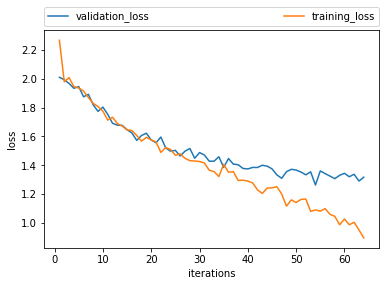

[2.0089083194732664,
 1.9920178055763245,
 1.9663265148798625,
 1.9329823493957519,
 1.9445663611094157,
 1.8741172909736634,
 1.891366195678711,
 1.8183551192283631,
 1.7735421220461527,
 1.8030615011850992,
 1.753110162417094,
 1.6912304520606996,
 1.6779672185579935,
 1.6764853715896606,
 1.6469167311986288,
 1.6248172720273335,
 1.5730508267879486,
 1.6070278922716776,
 1.6224488814671834,
 1.575693921248118,
 1.556779932975769,
 1.59625031153361,
 1.521470061937968,
 1.4986480275789897,
 1.5040237108866374,
 1.4653663794199625,
 1.4986755887667338,
 1.517119860649109,
 1.4495089928309122,
 1.4887892127037048,
 1.4720153133074443,
 1.4295433501402537,
 1.4290190895398458,
 1.4600691080093384,
 1.3868909657001496,
 1.4475836038589478,
 1.4090686082839965,
 1.404997670650482,
 1.3790865421295166,
 1.3758519927660624,
 1.3862550298372904,
 1.385916777451833,
 1.401378039518992,
 1.3948899467786153,
 1.3765206575393676,
 1.3353099346160888,
 1.3108585000038147,
 1.356727304061254,
 1.3

In [73]:
train_save('age', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.2724915385246276, validation_error:2.018036276102066
Best loss improvement from inf to 2.018036276102066 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9852904558181763, validation_error:2.000723268304552
Best loss improvement from 2.018036276102066 to 2.000723268304552 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9816041159629822, validation_error:1.9483420763696944
Best loss improvement from 2.000723268304552 to 1.9483420763696944 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9587277722358705, validation_error:1.9653160955224718
minibatch:1, epoch:2, iteration:249, training_error:1.9296211671829224, validation_error:1.9347698560782842
Best loss improvement from 1.9483420763696944 to 1.9347698560782842 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:1.9112021374702453, validation_error:1.904223552771977
Best loss improvement from 1.9347698560782842 to 1.90

minibatch:21, epoch:12, iteration:2749, training_error:1.0012763345241547, validation_error:1.2524323676313673
minibatch:71, epoch:12, iteration:2799, training_error:0.9897117042541503, validation_error:1.2675596347876958
minibatch:121, epoch:12, iteration:2849, training_error:0.9609069561958313, validation_error:1.277423375419208
minibatch:171, epoch:12, iteration:2899, training_error:1.0221229112148285, validation_error:1.234618651015418
minibatch:221, epoch:12, iteration:2949, training_error:0.9898171961307526, validation_error:1.1922368577548437
Best loss improvement from 1.2176963197333472 to 1.1922368577548437 in epoch 12
minibatch:23, epoch:13, iteration:2999, training_error:0.9520523381233216, validation_error:1.2526331969669886
minibatch:73, epoch:13, iteration:3049, training_error:0.8963276302814484, validation_error:1.1890661056552614
Best loss improvement from 1.1922368577548437 to 1.1890661056552614 in epoch 13
minibatch:123, epoch:13, iteration:3099, training_error:0.9404

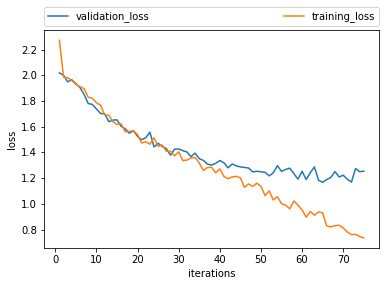

[2.018036276102066,
 2.000723268304552,
 1.9483420763696944,
 1.9653160955224718,
 1.9347698560782842,
 1.904223552771977,
 1.850729158946446,
 1.780116787978581,
 1.7734894709927695,
 1.7379392215183802,
 1.7024867151464735,
 1.700772498335157,
 1.6390352887766702,
 1.6510632123265947,
 1.653440466948918,
 1.6030386260577612,
 1.5839282870292664,
 1.5491003266402654,
 1.5683766305446625,
 1.5246544991220747,
 1.4989228589194161,
 1.5137116823877608,
 1.5572203142302377,
 1.4421995963369096,
 1.4710531107016973,
 1.446422666311264,
 1.429222047328949,
 1.3783687438283647,
 1.42528720838683,
 1.4264970975262778,
 1.4132873586245946,
 1.4037541917392187,
 1.366278384413038,
 1.394313360963549,
 1.350975011076246,
 1.3380234496934074,
 1.3091558601175035,
 1.30116882281644,
 1.3154415956565313,
 1.3366047143936157,
 1.3195054296936308,
 1.2799591251782008,
 1.3102284797600336,
 1.2950402796268463,
 1.2873815255505698,
 1.2830278000661306,
 1.278260377900941,
 1.2483691828591483,
 1.253129

In [74]:
train_save('age', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.273860840797424, validation_error:2.0558967819580665
Best loss improvement from inf to 2.0558967819580665 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.052778887748718, validation_error:2.0074098156048703
Best loss improvement from 2.0558967819580665 to 2.0074098156048703 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.0238713574409486, validation_error:1.9966896864084096
Best loss improvement from 2.0074098156048703 to 1.9966896864084096 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9898505640029907, validation_error:1.9890798834654002
Best loss improvement from 1.9966896864084096 to 1.9890798834654002 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.9564871406555175, validation_error:1.9609668346551747
Best loss improvement from 1.9890798834654002 to 1.9609668346551747 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.9611617398262025, vali

minibatch:229, epoch:11, iteration:2599, training_error:1.2890127086639405, validation_error:1.383606663117042
minibatch:42, epoch:12, iteration:2649, training_error:1.2455405902862549, validation_error:1.374935241845938
minibatch:92, epoch:12, iteration:2699, training_error:1.243019301891327, validation_error:1.373651852974525
minibatch:142, epoch:12, iteration:2749, training_error:1.24708456158638, validation_error:1.3548153684689448
minibatch:192, epoch:12, iteration:2799, training_error:1.220484619140625, validation_error:1.3954038619995117
minibatch:5, epoch:13, iteration:2849, training_error:1.278124908208847, validation_error:1.3469449098293598
minibatch:55, epoch:13, iteration:2899, training_error:1.2269229650497437, validation_error:1.3367314820106213
Best loss improvement from 1.3421063789954553 to 1.3367314820106213 in epoch 13
minibatch:105, epoch:13, iteration:2949, training_error:1.202186154127121, validation_error:1.355855107307434
minibatch:155, epoch:13, iteration:2999

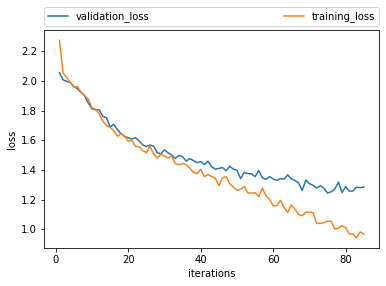

[2.0558967819580665,
 2.0074098156048703,
 1.9966896864084096,
 1.9890798834654002,
 1.9609668346551747,
 1.947283263389881,
 1.9210560872004583,
 1.8980981432474577,
 1.84894852913343,
 1.8114845431767976,
 1.8058908719282885,
 1.804137307863969,
 1.7606446697161748,
 1.7509248027434716,
 1.6904554229516249,
 1.7072283488053541,
 1.6714130364931548,
 1.6444751299344575,
 1.6250252586144667,
 1.6169156615550702,
 1.6077033143777113,
 1.617624003153581,
 1.594480051444127,
 1.568565478691688,
 1.5579853699757502,
 1.5679142750226533,
 1.560689077927516,
 1.516933872149541,
 1.5084302517083974,
 1.535776239175063,
 1.5146097265757048,
 1.5002823517872736,
 1.4768198224214406,
 1.4979506134986877,
 1.4891764384049635,
 1.4591891719744756,
 1.4766470744059637,
 1.4631993908148546,
 1.4490716549066396,
 1.4565284985762377,
 1.4360264814816988,
 1.4589605377270625,
 1.4222109226080089,
 1.4050794931558461,
 1.4104049572577844,
 1.416449798987462,
 1.3948395573175871,
 1.424560079207787,
 1.4

In [75]:
train_save('age', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.265900685787201, validation_error:2.0287565116224617
Best loss improvement from inf to 2.0287565116224617 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.987644326686859, validation_error:1.9955645881850144
Best loss improvement from 2.0287565116224617 to 1.9955645881850144 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9625472903251648, validation_error:1.9665547979289089
Best loss improvement from 1.9955645881850144 to 1.9665547979289089 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9568208122253419, validation_error:1.9570179273342263
Best loss improvement from 1.9665547979289089 to 1.9570179273342263 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9399961280822753, validation_error:1.9665126636110504
minibatch:41, epoch:2, iteration:299, training_error:1.9289869356155396, validation_error:1.9422481964374412
Best loss improvement from 1.9570179273342263 

minibatch:227, epoch:10, iteration:2549, training_error:1.2698209691047668, validation_error:1.3052805374408591
Best loss improvement from 1.3414857510862679 to 1.3052805374408591 in epoch 10
minibatch:19, epoch:11, iteration:2599, training_error:1.19989364027977, validation_error:1.3015525916527058
Best loss improvement from 1.3052805374408591 to 1.3015525916527058 in epoch 11
minibatch:69, epoch:11, iteration:2649, training_error:1.2355960941314696, validation_error:1.3441747015920178
minibatch:119, epoch:11, iteration:2699, training_error:1.2136542761325837, validation_error:1.2753356448535262
Best loss improvement from 1.3015525916527058 to 1.2753356448535262 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:1.2383186721801758, validation_error:1.3396160849209489
minibatch:219, epoch:11, iteration:2799, training_error:1.2266426742076875, validation_error:1.3222525859701222
minibatch:11, epoch:12, iteration:2849, training_error:1.198485312461853, validation_error:1

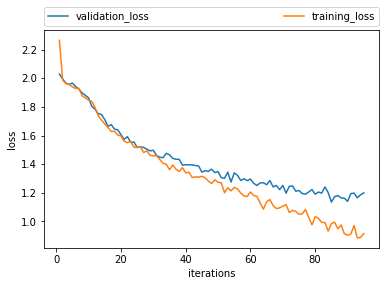

[2.0287565116224617,
 1.9955645881850144,
 1.9665547979289089,
 1.9570179273342263,
 1.9665126636110504,
 1.9422481964374412,
 1.9248157081932857,
 1.898250049558179,
 1.8810757028645482,
 1.8638681954350964,
 1.8043428495012481,
 1.7836413342377235,
 1.753320052705962,
 1.747004743280082,
 1.7118629998174206,
 1.6640733069386975,
 1.6763776951822742,
 1.644800983626267,
 1.6403243418397575,
 1.6066468748553047,
 1.5733350926432117,
 1.592434340509875,
 1.552894111337333,
 1.5543378303790916,
 1.5175755229489556,
 1.5209879751863151,
 1.5173563093974674,
 1.504545072029377,
 1.4927929763136238,
 1.4973429112598813,
 1.4604937783603011,
 1.4487365360917717,
 1.4449391241731315,
 1.4756077980173046,
 1.465606718227781,
 1.4402776586598363,
 1.4349334445492974,
 1.433527843705539,
 1.3929608978074173,
 1.395663573824126,
 1.3959460135163932,
 1.3950339432420402,
 1.390473620644931,
 1.387442541533503,
 1.3440593645490448,
 1.354956918749316,
 1.349571606208538,
 1.3648798835688625,
 1.341

In [76]:
train_save('age', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.2561786818504332, validation_error:2.010768853384873
Best loss improvement from inf to 2.010768853384873 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.008848490715027, validation_error:1.977394621947716
Best loss improvement from 2.010768853384873 to 1.977394621947716 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.982563931941986, validation_error:1.9503022884500438
Best loss improvement from 1.977394621947716 to 1.9503022884500438 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9380510568618774, validation_error:1.9441652092440376
Best loss improvement from 1.9503022884500438 to 1.9441652092440376 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9416911888122559, validation_error:1.9359068048411403
Best loss improvement from 1.9441652092440376 to 1.9359068048411403 in epoch 1
minibatch:45, epoch:2, iteration:299, training_error:1.940516095161438, validation

minibatch:109, epoch:11, iteration:2649, training_error:1.2829543876647949, validation_error:1.3724821477100766
minibatch:159, epoch:11, iteration:2699, training_error:1.2643194091320038, validation_error:1.339322513547437
Best loss improvement from 1.3531999834652604 to 1.339322513547437 in epoch 11
minibatch:209, epoch:11, iteration:2749, training_error:1.288454978466034, validation_error:1.3059805426104316
Best loss improvement from 1.339322513547437 to 1.3059805426104316 in epoch 11
minibatch:5, epoch:12, iteration:2799, training_error:1.3111441445350647, validation_error:1.359411543813245
minibatch:55, epoch:12, iteration:2849, training_error:1.2382716345787048, validation_error:1.3458136854500606
minibatch:105, epoch:12, iteration:2899, training_error:1.2385924208164214, validation_error:1.3413171973721734
minibatch:155, epoch:12, iteration:2949, training_error:1.2395784962177276, validation_error:1.2907523430626968
Best loss improvement from 1.3059805426104316 to 1.2907523430626

minibatch:7, epoch:24, iteration:5849, training_error:0.7808987513184548, validation_error:1.198175048005992
minibatch:57, epoch:24, iteration:5899, training_error:0.7657489728927612, validation_error:1.2323526657860855
minibatch:107, epoch:24, iteration:5949, training_error:0.7259881007671356, validation_error:1.2368895904771213
minibatch:157, epoch:24, iteration:5999, training_error:0.7547572559118271, validation_error:1.202646557627053
minibatch:207, epoch:24, iteration:6049, training_error:0.7614033877849579, validation_error:1.2126231522395694
minibatch:3, epoch:25, iteration:6099, training_error:0.7311082112789155, validation_error:1.2005558260555924
minibatch:53, epoch:25, iteration:6149, training_error:0.6753438794612885, validation_error:1.2150156580168625
minibatch:103, epoch:25, iteration:6199, training_error:0.7347118020057678, validation_error:1.1709458663545806
Best loss improvement from 1.1719536534671127 to 1.1709458663545806 in epoch 25
minibatch:153, epoch:25, iterati

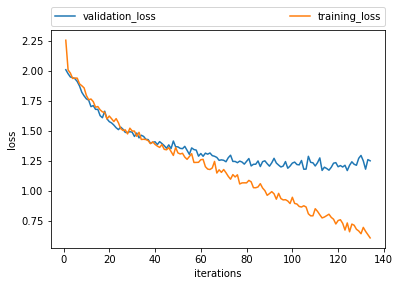

[2.010768853384873,
 1.977394621947716,
 1.9503022884500438,
 1.9441652092440376,
 1.9359068048411403,
 1.9125831579339916,
 1.8750352736177116,
 1.8228924027804672,
 1.7928511397591953,
 1.7680963894416546,
 1.7569124082039143,
 1.7033106869664685,
 1.7118093926331093,
 1.680590559696329,
 1.6806134602119183,
 1.6281600573967243,
 1.6108051004080937,
 1.6652564509161587,
 1.6015668161984147,
 1.578338594272219,
 1.5675693627061515,
 1.5496218779991413,
 1.5275371855702893,
 1.5118608968011265,
 1.5326628397250999,
 1.5151430080676902,
 1.4885383926588913,
 1.488462941399936,
 1.4945274550339271,
 1.4908856770087933,
 1.45491100179738,
 1.483643313934063,
 1.4429087515535026,
 1.465033087237128,
 1.4552232931400169,
 1.4311343143726218,
 1.4288953748242608,
 1.397616509733529,
 1.4063424118633927,
 1.4105226829134185,
 1.3869983307246505,
 1.4118256733335297,
 1.3959131487484635,
 1.3786800853137313,
 1.3566928115384331,
 1.3848699290176918,
 1.3539625241838653,
 1.4169422141436874,
 1

In [77]:
train_save('age', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.240755760669708, validation_error:2.0383480707804362
Best loss improvement from inf to 2.0383480707804362 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.001638686656952, validation_error:1.9738932291666667
Best loss improvement from 2.0383480707804362 to 1.9738932291666667 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.984114053249359, validation_error:1.951635189851125
Best loss improvement from 1.9738932291666667 to 1.951635189851125 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.969568021297455, validation_error:1.9291221539179484
Best loss improvement from 1.951635189851125 to 1.9291221539179484 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9178259515762328, validation_error:1.9259720643361409
Best loss improvement from 1.9291221539179484 to 1.9259720643361409 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:1.9013363170623778, validati

minibatch:199, epoch:11, iteration:2799, training_error:1.2557066535949708, validation_error:1.3594983657201132
minibatch:249, epoch:11, iteration:2849, training_error:1.241489088535309, validation_error:1.3264686067899067
Best loss improvement from 1.350666582584381 to 1.3264686067899067 in epoch 11
minibatch:39, epoch:12, iteration:2899, training_error:1.2068519461154938, validation_error:1.3179891586303711
Best loss improvement from 1.3264686067899067 to 1.3179891586303711 in epoch 12
minibatch:89, epoch:12, iteration:2949, training_error:1.1984861278533936, validation_error:1.336970051129659
minibatch:139, epoch:12, iteration:2999, training_error:1.188028049468994, validation_error:1.3483567456404368
minibatch:189, epoch:12, iteration:3049, training_error:1.1919025897979736, validation_error:1.3379922350247702
minibatch:239, epoch:12, iteration:3099, training_error:1.2005437994003296, validation_error:1.3550349473953247
minibatch:29, epoch:13, iteration:3149, training_error:1.19426

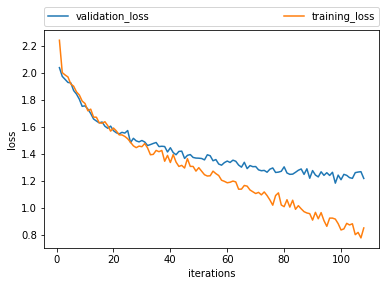

[2.0383480707804362,
 1.9738932291666667,
 1.951635189851125,
 1.9291221539179484,
 1.9259720643361409,
 1.8692107597986858,
 1.8430352409680684,
 1.8051784833272297,
 1.752641506989797,
 1.7559746225674948,
 1.732218857606252,
 1.6994610190391541,
 1.659257984161377,
 1.6442903359731038,
 1.6304033954938253,
 1.6368659297625223,
 1.6055208206176759,
 1.5906171878178914,
 1.6064335346221923,
 1.5729950984319052,
 1.5574674447377523,
 1.5490748246510824,
 1.5604544440905253,
 1.5549768686294556,
 1.5738245050112407,
 1.4845815698305767,
 1.5163883805274962,
 1.4973652084668478,
 1.490109395980835,
 1.500228460629781,
 1.4890777428944906,
 1.462989761432012,
 1.4702359517415364,
 1.4784955541292826,
 1.485494045416514,
 1.455391271909078,
 1.4577269951502483,
 1.4557546575864155,
 1.4154738704363505,
 1.4468279639879862,
 1.411013126373291,
 1.3951015651226044,
 1.4195980191230775,
 1.421584971745809,
 1.3679463386535644,
 1.390437157948812,
 1.3965952475865682,
 1.3751339832941691,
 1.3

In [78]:
train_save('age', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.282261023521423, validation_error:2.02414761696543
Best loss improvement from inf to 2.02414761696543 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9898842883110046, validation_error:1.9803694997514998
Best loss improvement from 2.02414761696543 to 1.9803694997514998 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9804757404327393, validation_error:1.962890774011612
Best loss improvement from 1.9803694997514998 to 1.962890774011612 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9748501920700072, validation_error:1.9547579416206904
Best loss improvement from 1.962890774011612 to 1.9547579416206904 in epoch 1
minibatch:1, epoch:2, iteration:249, training_error:1.9445245337486268, validation_error:1.9506290767874037
Best loss improvement from 1.9547579416206904 to 1.9506290767874037 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:1.9479610586166383, validation_er

minibatch:169, epoch:11, iteration:2649, training_error:1.2432511448860168, validation_error:1.2696754123483385
Best loss improvement from 1.2703090416533607 to 1.2696754123483385 in epoch 11
minibatch:219, epoch:11, iteration:2699, training_error:1.2093753612041473, validation_error:1.282407249723162
minibatch:21, epoch:12, iteration:2749, training_error:1.227461519241333, validation_error:1.2715731667620795
minibatch:71, epoch:12, iteration:2799, training_error:1.2023002195358277, validation_error:1.3022237164633614
minibatch:121, epoch:12, iteration:2849, training_error:1.160592577457428, validation_error:1.289412749665124
minibatch:171, epoch:12, iteration:2899, training_error:1.215654672384262, validation_error:1.2125632805483681
Best loss improvement from 1.2696754123483385 to 1.2125632805483681 in epoch 12
minibatch:221, epoch:12, iteration:2949, training_error:1.200148365497589, validation_error:1.2737655341625214
minibatch:23, epoch:13, iteration:2999, training_error:1.1663988

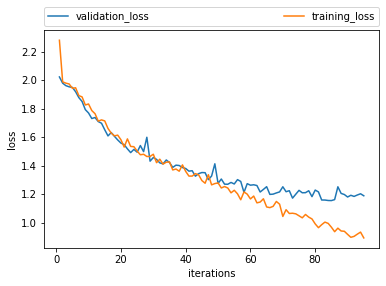

[2.02414761696543,
 1.9803694997514998,
 1.962890774011612,
 1.9547579416206904,
 1.9506290767874037,
 1.9202789579119002,
 1.878892421722412,
 1.8515132793358393,
 1.7943852373531886,
 1.7705696650913783,
 1.7317101870264326,
 1.7389363050460815,
 1.7103758709771293,
 1.698597299201148,
 1.6526607700756617,
 1.6095409989356995,
 1.633117037160056,
 1.606546197618757,
 1.5812626438481467,
 1.559121412890298,
 1.5481533663613456,
 1.5186423787048884,
 1.4922089448996954,
 1.5145438015460968,
 1.49519544839859,
 1.541809971843447,
 1.4990309945174627,
 1.6000310352870397,
 1.4320268545831953,
 1.4577506397451674,
 1.4445939574922835,
 1.4200652071407862,
 1.4129766779286521,
 1.4403604907648904,
 1.422400461775916,
 1.3883321625845773,
 1.4039224088191986,
 1.4014537802764349,
 1.387108211006437,
 1.3803872551236833,
 1.3617725244590215,
 1.3648476685796465,
 1.3264132567814417,
 1.3444653281143732,
 1.3519926794937678,
 1.3509386735303062,
 1.3018769515412194,
 1.327506159033094,
 1.413

In [79]:
train_save('age', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.292452256679535, validation_error:2.085195087469541
Best loss improvement from inf to 2.085195087469541 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.040833191871643, validation_error:2.0248325879757223
Best loss improvement from 2.085195087469541 to 2.0248325879757223 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.006819899082184, validation_error:2.0122244770710287
Best loss improvement from 2.0248325879757223 to 2.0122244770710287 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9932024431228639, validation_error:1.9876940433795636
Best loss improvement from 2.0122244770710287 to 1.9876940433795636 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.9738969445228576, validation_error:1.9675999329640315
Best loss improvement from 1.9876940433795636 to 1.9675999329640315 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.9558420753479004, validati

minibatch:179, epoch:11, iteration:2549, training_error:1.4378646278381348, validation_error:1.428089059316195
Best loss improvement from 1.433245457135714 to 1.428089059316195 in epoch 11
minibatch:229, epoch:11, iteration:2599, training_error:1.4053673267364502, validation_error:1.4225053237034724
Best loss improvement from 1.428089059316195 to 1.4225053237034724 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:1.3885932111740111, validation_error:1.4194901218781104
Best loss improvement from 1.4225053237034724 to 1.4194901218781104 in epoch 12
minibatch:92, epoch:12, iteration:2699, training_error:1.4034975290298461, validation_error:1.4029239049324622
Best loss improvement from 1.4194901218781104 to 1.4029239049324622 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.3929981446266175, validation_error:1.432312616935143
minibatch:192, epoch:12, iteration:2799, training_error:1.398939254283905, validation_error:1.385749115393712
Best loss improve

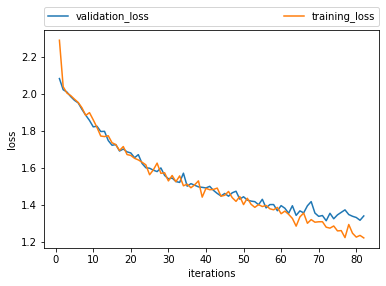

[2.085195087469541,
 2.0248325879757223,
 2.0122244770710287,
 1.9876940433795636,
 1.9675999329640315,
 1.9536235194939833,
 1.9184319239396315,
 1.8871020445456872,
 1.8588642661388104,
 1.8240756209080036,
 1.8272836070794325,
 1.7987626836850092,
 1.7997910930560186,
 1.7498104251348054,
 1.7245235443115234,
 1.7280910932100737,
 1.6933695582243113,
 1.7041579668338482,
 1.6888228746560903,
 1.6828757432790904,
 1.6571360459694495,
 1.6737265999500568,
 1.6259048214325538,
 1.602745886032398,
 1.6003441443810096,
 1.5896124518834627,
 1.5820511441964369,
 1.6017824686490572,
 1.5612043967613807,
 1.5430724162321825,
 1.5472642183303833,
 1.528315755037161,
 1.5235097775092492,
 1.5734401391102717,
 1.5030259856810937,
 1.5168975041462824,
 1.5082768706174998,
 1.499512608234699,
 1.4969228506088257,
 1.493690156019651,
 1.502355511371906,
 1.480548280936021,
 1.4639463012035077,
 1.4502575397491455,
 1.4638155744625971,
 1.4488168633901155,
 1.4675226578345666,
 1.475843342450949,


In [80]:
train_save('age', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.2266752195358275, validation_error:2.038122353882625
Best loss improvement from inf to 2.038122353882625 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.970407123565674, validation_error:1.982737841277287
Best loss improvement from 2.038122353882625 to 1.982737841277287 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9487710547447206, validation_error:1.960577788024113
Best loss improvement from 1.982737841277287 to 1.960577788024113 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9473949027061463, validation_error:1.961804747581482
minibatch:249, epoch:1, iteration:249, training_error:1.9595123147964477, validation_error:1.93545663356781
Best loss improvement from 1.960577788024113 to 1.93545663356781 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.9154385662078857, validation_error:1.9057491729999412
Best loss improvement from 1.93545663356781 to 1.9057491729

minibatch:119, epoch:11, iteration:2699, training_error:1.3209099411964416, validation_error:1.3598726124599063
Best loss improvement from 1.3605875187906726 to 1.3598726124599063 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:1.3361663627624512, validation_error:1.3667374972639412
minibatch:219, epoch:11, iteration:2799, training_error:1.2981506323814391, validation_error:1.3809354387480637
minibatch:11, epoch:12, iteration:2849, training_error:1.2906958889961242, validation_error:1.313075669880571
Best loss improvement from 1.3598726124599063 to 1.313075669880571 in epoch 12
minibatch:61, epoch:12, iteration:2899, training_error:1.2911721420288087, validation_error:1.339440892482626
minibatch:111, epoch:12, iteration:2949, training_error:1.2986313605308533, validation_error:1.3681690569581657
minibatch:161, epoch:12, iteration:2999, training_error:1.2792349219322205, validation_error:1.3239213063799102
minibatch:211, epoch:12, iteration:3049, training_error:1.284

minibatch:123, epoch:23, iteration:5799, training_error:1.0142314910888672, validation_error:1.155807521836511
minibatch:173, epoch:23, iteration:5849, training_error:1.0004667294025422, validation_error:1.1359165269753029
Best loss improvement from 1.137227962756979 to 1.1359165269753029 in epoch 23
minibatch:223, epoch:23, iteration:5899, training_error:1.0028024518489838, validation_error:1.1781179678851161
minibatch:15, epoch:24, iteration:5949, training_error:0.9492245626449585, validation_error:1.1507882167553078
minibatch:65, epoch:24, iteration:5999, training_error:0.9576154088973999, validation_error:1.180803866221987
minibatch:115, epoch:24, iteration:6049, training_error:1.0153658199310303, validation_error:1.173602137072333
minibatch:165, epoch:24, iteration:6099, training_error:0.983736264705658, validation_error:1.1677597124001076
minibatch:215, epoch:24, iteration:6149, training_error:0.9822368645668029, validation_error:1.209324637363697
minibatch:7, epoch:25, iteration

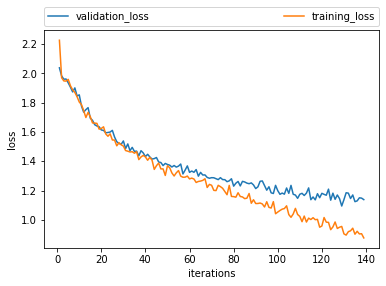

[2.038122353882625,
 1.982737841277287,
 1.960577788024113,
 1.961804747581482,
 1.93545663356781,
 1.9057491729999412,
 1.873661678412865,
 1.901094157120277,
 1.845782469058859,
 1.8535224980321423,
 1.7769289551110103,
 1.7351097485114788,
 1.7524696629622887,
 1.7661401197828095,
 1.694286741059402,
 1.679301171467222,
 1.649727278742297,
 1.6407115336122184,
 1.6351822285816586,
 1.6135871533689827,
 1.6106825450371052,
 1.5944069089560673,
 1.5964718933763176,
 1.5994255460541824,
 1.6109548560504257,
 1.5656661494024868,
 1.5331643737595657,
 1.5220149673264602,
 1.5154022060591599,
 1.5386872949271366,
 1.4862716937887257,
 1.5182958553577293,
 1.4720671629083568,
 1.494711764927568,
 1.467397665155345,
 1.4690163094421913,
 1.4368787469535038,
 1.4721049933597958,
 1.4567324745243992,
 1.431716536653453,
 1.447379757618082,
 1.4292559911464822,
 1.4148081253314841,
 1.4180435538291931,
 1.4254216202374161,
 1.3947051927961152,
 1.391104977706383,
 1.370284914970398,
 1.3849657

In [81]:
train_save('age', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.252940797805786, validation_error:2.023499809462449
Best loss improvement from inf to 2.023499809462449 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9952252388000489, validation_error:1.968937606647097
Best loss improvement from 2.023499809462449 to 1.968937606647097 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9921751928329468, validation_error:1.984743253938083
minibatch:199, epoch:1, iteration:199, training_error:1.9420669317245483, validation_error:1.9332088560893619
Best loss improvement from 1.968937606647097 to 1.9332088560893619 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.943546392917633, validation_error:1.93394346072756
minibatch:45, epoch:2, iteration:299, training_error:1.9610426282882691, validation_error:1.9043666658730343
Best loss improvement from 1.9332088560893619 to 1.9043666658730343 in epoch 2
minibatch:95, epoch:2, iteration:349, training_error:1.

minibatch:59, epoch:11, iteration:2599, training_error:1.393857066631317, validation_error:1.369513306124457
Best loss improvement from 1.3792623281478882 to 1.369513306124457 in epoch 11
minibatch:109, epoch:11, iteration:2649, training_error:1.4042444705963135, validation_error:1.3666951286381688
Best loss improvement from 1.369513306124457 to 1.3666951286381688 in epoch 11
minibatch:159, epoch:11, iteration:2699, training_error:1.354666655063629, validation_error:1.3500616262698997
Best loss improvement from 1.3666951286381688 to 1.3500616262698997 in epoch 11
minibatch:209, epoch:11, iteration:2749, training_error:1.3744223093986512, validation_error:1.3449802563108246
Best loss improvement from 1.3500616262698997 to 1.3449802563108246 in epoch 11
minibatch:5, epoch:12, iteration:2799, training_error:1.3898253428936005, validation_error:1.3990905860374714
minibatch:55, epoch:12, iteration:2849, training_error:1.3591354012489318, validation_error:1.352056519738559
minibatch:105, epo

minibatch:215, epoch:22, iteration:5549, training_error:1.1169725751876831, validation_error:1.2074015880453175
minibatch:11, epoch:23, iteration:5599, training_error:1.157356264591217, validation_error:1.2500328812105903
minibatch:61, epoch:23, iteration:5649, training_error:1.088719415664673, validation_error:1.2077051010625115
minibatch:111, epoch:23, iteration:5699, training_error:1.098002963066101, validation_error:1.2041471456659252
minibatch:161, epoch:23, iteration:5749, training_error:1.127664498090744, validation_error:1.216917218833134
minibatch:211, epoch:23, iteration:5799, training_error:1.08331934094429, validation_error:1.2230832412325103
minibatch:7, epoch:24, iteration:5849, training_error:1.0536345589160918, validation_error:1.241022605320503
minibatch:57, epoch:24, iteration:5899, training_error:1.0605139112472535, validation_error:1.162552702015844
Best loss improvement from 1.1916697744665474 to 1.162552702015844 in epoch 24
minibatch:107, epoch:24, iteration:5949

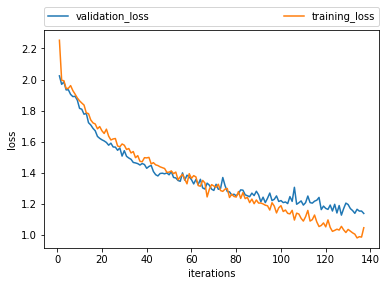

[2.023499809462449,
 1.968937606647097,
 1.984743253938083,
 1.9332088560893619,
 1.93394346072756,
 1.9043666658730343,
 1.8900547438654407,
 1.8920442975800613,
 1.8673213103721882,
 1.8143753388832355,
 1.8087724652783623,
 1.7764628837848533,
 1.782421062732565,
 1.7221212592618218,
 1.7075200738578007,
 1.6858033147351494,
 1.6700844312536305,
 1.6337615662607654,
 1.6213363820108875,
 1.611936589767193,
 1.6046686336911957,
 1.5948252266850964,
 1.5773021681555386,
 1.5901766645497288,
 1.5658769648650597,
 1.5649197553766185,
 1.5445042725267082,
 1.5594524268446297,
 1.5071091980769717,
 1.5418913158877143,
 1.505537879878077,
 1.4947552927609147,
 1.4864480248812972,
 1.4661647410228336,
 1.463106915868562,
 1.4585837742377972,
 1.4495861818050515,
 1.4594574755635754,
 1.4526259159219677,
 1.4285734028651798,
 1.4402435195857082,
 1.4472372984064037,
 1.4077178445355645,
 1.387472991285653,
 1.3792623281478882,
 1.3951247231713657,
 1.3969234639200672,
 1.3929536835900669,
 1

In [82]:
train_save('age', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.2745560693740843, validation_error:2.028748869895935
Best loss improvement from inf to 2.028748869895935 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.007572410106659, validation_error:1.9992234071095785
Best loss improvement from 2.028748869895935 to 1.9992234071095785 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9987537932395936, validation_error:1.964198390642802
Best loss improvement from 1.9992234071095785 to 1.964198390642802 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.972380244731903, validation_error:1.9296995957692464
Best loss improvement from 1.964198390642802 to 1.9296995957692464 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.956687159538269, validation_error:1.9284039417902628
Best loss improvement from 1.9296995957692464 to 1.9284039417902628 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:1.9318905258178711, validation

minibatch:259, epoch:10, iteration:2599, training_error:1.379140968322754, validation_error:1.4012977321942648
minibatch:49, epoch:11, iteration:2649, training_error:1.3344833612442017, validation_error:1.416668216387431
minibatch:99, epoch:11, iteration:2699, training_error:1.395792829990387, validation_error:1.391413724422455
minibatch:149, epoch:11, iteration:2749, training_error:1.3606210875511169, validation_error:1.4222299456596375
minibatch:199, epoch:11, iteration:2799, training_error:1.3800805592536927, validation_error:1.4166718562444052
minibatch:249, epoch:11, iteration:2849, training_error:1.3240419387817384, validation_error:1.3722070276737213
Best loss improvement from 1.3824487765630087 to 1.3722070276737213 in epoch 11
minibatch:39, epoch:12, iteration:2899, training_error:1.3566631472110748, validation_error:1.3879764238993326
minibatch:89, epoch:12, iteration:2949, training_error:1.3314134168624878, validation_error:1.3725366195042927
minibatch:139, epoch:12, iterati

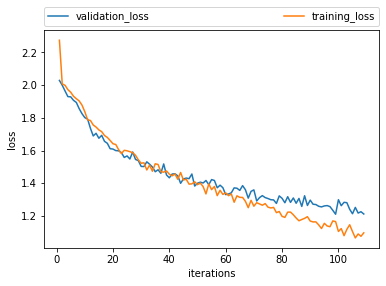

[2.028748869895935,
 1.9992234071095785,
 1.964198390642802,
 1.9296995957692464,
 1.9284039417902628,
 1.9069605827331544,
 1.8940380454063415,
 1.8564056555430095,
 1.8256617069244385,
 1.8013710260391236,
 1.792473312218984,
 1.7361335555712383,
 1.6892191171646118,
 1.7053524216016134,
 1.6751237630844116,
 1.6927292307217916,
 1.6562308629353841,
 1.6441693544387816,
 1.6110352754592896,
 1.6088584502538046,
 1.5995966871579488,
 1.5982873797416688,
 1.5873642762502034,
 1.5575594226519267,
 1.5669630527496339,
 1.5481104175249736,
 1.5907552639643352,
 1.5453825434048971,
 1.5381563186645508,
 1.50275310476621,
 1.5019370754559835,
 1.5308555285135905,
 1.5160501758257547,
 1.4991546154022217,
 1.4702444672584534,
 1.482279121875763,
 1.4609286308288574,
 1.51788702805837,
 1.4504485130310059,
 1.4330543080965679,
 1.4561230540275574,
 1.457659157117208,
 1.4451142072677612,
 1.3994837482770284,
 1.425826040903727,
 1.4314054648081462,
 1.4278645157814025,
 1.4562658468882244,
 1

In [83]:
train_save('age', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.2787711381912232, validation_error:2.0142517941338673
Best loss improvement from inf to 2.0142517941338673 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.007719359397888, validation_error:1.9802207904202598
Best loss improvement from 2.0142517941338673 to 1.9802207904202598 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9776310014724732, validation_error:1.9802163413592748
Best loss improvement from 1.9802207904202598 to 1.9802163413592748 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9442493867874147, validation_error:1.944078015429633
Best loss improvement from 1.9802163413592748 to 1.944078015429633 in epoch 1
minibatch:1, epoch:2, iteration:249, training_error:1.934415521621704, validation_error:1.9334181334291185
Best loss improvement from 1.944078015429633 to 1.9334181334291185 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:1.907813868522644, validatio

minibatch:169, epoch:11, iteration:2649, training_error:1.3357434010505675, validation_error:1.3110545192446028
Best loss improvement from 1.3327162861824036 to 1.3110545192446028 in epoch 11
minibatch:219, epoch:11, iteration:2699, training_error:1.3584706330299376, validation_error:1.3240764055933272
minibatch:21, epoch:12, iteration:2749, training_error:1.3433919334411621, validation_error:1.3203817393098558
minibatch:71, epoch:12, iteration:2799, training_error:1.3246122920513153, validation_error:1.295752927660942
Best loss improvement from 1.3110545192446028 to 1.295752927660942 in epoch 12
minibatch:121, epoch:12, iteration:2849, training_error:1.322538275718689, validation_error:1.298252591064998
minibatch:171, epoch:12, iteration:2899, training_error:1.3353130340576171, validation_error:1.2867818517344338
Best loss improvement from 1.295752927660942 to 1.2867818517344338 in epoch 12
minibatch:221, epoch:12, iteration:2949, training_error:1.303779022693634, validation_error:1.3

minibatch:143, epoch:23, iteration:5599, training_error:1.0164437127113342, validation_error:1.189958808677537
minibatch:193, epoch:23, iteration:5649, training_error:1.029635455608368, validation_error:1.1603316579546248
minibatch:243, epoch:23, iteration:5699, training_error:1.0208413887023926, validation_error:1.126242961202349
Best loss improvement from 1.1367655439036233 to 1.126242961202349 in epoch 23
minibatch:45, epoch:24, iteration:5749, training_error:0.9797027850151062, validation_error:1.148232449378286
minibatch:95, epoch:24, iteration:5799, training_error:0.9479644107818603, validation_error:1.1557748700891222
minibatch:145, epoch:24, iteration:5849, training_error:1.0151665687561036, validation_error:1.1499466810907637
minibatch:195, epoch:24, iteration:5899, training_error:1.0180620515346528, validation_error:1.1594495517866952
minibatch:245, epoch:24, iteration:5949, training_error:1.0024001097679138, validation_error:1.1065281139952796
Best loss improvement from 1.12

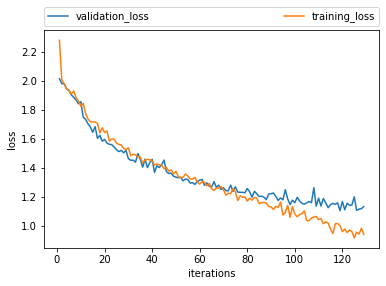

[2.0142517941338673,
 1.9802207904202598,
 1.9802163413592748,
 1.944078015429633,
 1.9334181334291185,
 1.9029270495687212,
 1.8864959733826774,
 1.8690912425518036,
 1.841975258929389,
 1.8568728182997023,
 1.7498407363891602,
 1.7345437918390547,
 1.7044302650860377,
 1.6821264156273432,
 1.645471406834466,
 1.6841032803058624,
 1.603648807321276,
 1.6244886730398451,
 1.584119860615049,
 1.5968834374632155,
 1.5713519666876112,
 1.5622888548033578,
 1.5602605428014482,
 1.5440108520644051,
 1.525347237076078,
 1.5127882872309004,
 1.5206731004374368,
 1.5042633286544256,
 1.5204008987971716,
 1.4638506514685494,
 1.4525509519236428,
 1.453637765986579,
 1.4394915699958801,
 1.4991349365030016,
 1.4602935399327959,
 1.405337359224047,
 1.4606399280684335,
 1.4023495486804418,
 1.4369186801569802,
 1.4597036838531494,
 1.3692996459347861,
 1.4149336985179357,
 1.4029185133320945,
 1.4228408804961614,
 1.454081884452275,
 1.3744274462972368,
 1.3618722770895277,
 1.3635353275707789,
 

In [84]:
train_save('age', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.2263731205463408, validation_error:0.7554345152996205
Best loss improvement from inf to 0.7554345152996205 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7264042723178864, validation_error:0.7041165939083806
Best loss improvement from 0.7554345152996205 to 0.7041165939083806 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7059075021743775, validation_error:0.6935496705549734
Best loss improvement from 0.7041165939083806 to 0.6935496705549734 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7109663367271424, validation_error:0.7066236624011287
minibatch:3, epoch:2, iteration:249, training_error:0.6839240074157715, validation_error:0.6850618146083973
Best loss improvement from 0.6935496705549734 to 0.6850618146083973 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6619612121582031, validation_error:0.6792801088756986
Best loss improvement from 0.6850618146083973 

minibatch:189, epoch:11, iteration:2649, training_error:0.33939718186855317, validation_error:0.42728549738725025
minibatch:239, epoch:11, iteration:2699, training_error:0.32052857756614683, validation_error:0.3976754419229649
Best loss improvement from 0.4038229104545381 to 0.3976754419229649 in epoch 11
minibatch:43, epoch:12, iteration:2749, training_error:0.31532007932662964, validation_error:0.3791363912600058
Best loss improvement from 0.3976754419229649 to 0.3791363912600058 in epoch 12
minibatch:93, epoch:12, iteration:2799, training_error:0.29114219844341277, validation_error:0.38480371402369606
minibatch:143, epoch:12, iteration:2849, training_error:0.29083745121955873, validation_error:0.40292506637396636
minibatch:193, epoch:12, iteration:2899, training_error:0.2982946413755417, validation_error:0.4050460717192403
minibatch:243, epoch:12, iteration:2949, training_error:0.3001749488711357, validation_error:0.3836577457410318
minibatch:47, epoch:13, iteration:2999, training_e

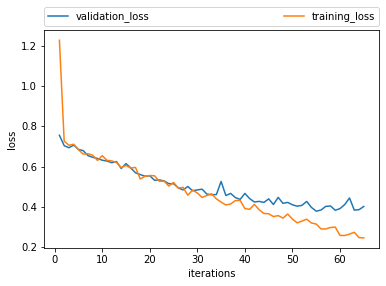

[0.7554345152996205,
 0.7041165939083806,
 0.6935496705549734,
 0.7066236624011287,
 0.6850618146083973,
 0.6792801088756986,
 0.6546488382198192,
 0.646237971606078,
 0.6403616512263263,
 0.631753804507079,
 0.6277903892375805,
 0.6194942461119758,
 0.6248573097917769,
 0.5907948679394193,
 0.6147978659029361,
 0.5933464555828659,
 0.5695177438082518,
 0.5605306503949342,
 0.5524335415275009,
 0.5546074597923843,
 0.5324266420470344,
 0.5338928500811259,
 0.5292150036052421,
 0.5154321955309974,
 0.5154771484710552,
 0.4947488043043349,
 0.48449276442880984,
 0.501466245562942,
 0.4804782536294725,
 0.48445453136055555,
 0.48817422875651606,
 0.4640146924389733,
 0.46064792739020455,
 0.4613835370099103,
 0.5265397319087276,
 0.45672316131768403,
 0.4672450003800569,
 0.4467015122925794,
 0.43732426895035637,
 0.4672173791461521,
 0.4414277705881331,
 0.4248684313562181,
 0.42765207809430583,
 0.4224908749262492,
 0.44015805257691276,
 0.41222780722158925,
 0.44746640434971563,
 0.418

In [85]:
train_save('gender', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.2464807629585266, validation_error:0.7391506186847029
Best loss improvement from inf to 0.7391506186847029 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7429389929771424, validation_error:0.7179406203072647
Best loss improvement from 0.7391506186847029 to 0.7179406203072647 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7087135553359986, validation_error:0.7146990792504673
Best loss improvement from 0.7179406203072647 to 0.7146990792504673 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7085246014595031, validation_error:0.6999136600001105
Best loss improvement from 0.7146990792504673 to 0.6999136600001105 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6975062167644501, validation_error:0.6857227128127525
Best loss improvement from 0.6999136600001105 to 0.6857227128127525 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6868242597579957, v

minibatch:77, epoch:12, iteration:2849, training_error:0.28893972367048265, validation_error:0.36289241344764317
minibatch:127, epoch:12, iteration:2899, training_error:0.2988859587907791, validation_error:0.3711910222111077
minibatch:177, epoch:12, iteration:2949, training_error:0.2911053031682968, validation_error:0.3685814142227173
Patience ran out at 2949. Ending training


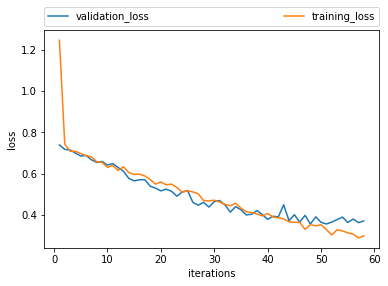

[0.7391506186847029,
 0.7179406203072647,
 0.7146990792504673,
 0.6999136600001105,
 0.6857227128127525,
 0.6884903661135969,
 0.6670752249915024,
 0.6547102167688567,
 0.6591186975610668,
 0.6415649395564507,
 0.6490549938432102,
 0.6296821565463625,
 0.6118807381597059,
 0.577236021387166,
 0.5652330466385546,
 0.5705642104148865,
 0.571122642221122,
 0.5396769817533165,
 0.5299966427786597,
 0.5169011621639646,
 0.5251447784489599,
 0.5147616010287712,
 0.49121647662129897,
 0.511557197776334,
 0.5181939468301576,
 0.46078083124654046,
 0.4475155390542129,
 0.46092557701571235,
 0.43836040537932824,
 0.4651850266703244,
 0.47008443906389435,
 0.44885880166086656,
 0.414021557775037,
 0.44028988994401075,
 0.4252319346214163,
 0.4002028266931402,
 0.40375873754764424,
 0.4211946325055484,
 0.4019411210099171,
 0.3789777699215659,
 0.39385464504874984,
 0.3911318039071971,
 0.44948061684082297,
 0.37200646847486496,
 0.40130092820216867,
 0.3655413631992093,
 0.39826422159014074,
 0.3

In [86]:
train_save('gender', 1, 0)

In [87]:
train_save('gender', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.2961095654964447, validation_error:0.728861035971806
Best loss improvement from inf to 0.728861035971806 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7439446711540222, validation_error:0.7123701942378077
Best loss improvement from 0.728861035971806 to 0.7123701942378077 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7125334489345551, validation_error:0.710474129380851
Best loss improvement from 0.7123701942378077 to 0.710474129380851 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7055565726757049, validation_error:0.7007434450346848
Best loss improvement from 0.710474129380851 to 0.7007434450346848 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.694799337387085, validation_error:0.7034888555263651
minibatch:39, epoch:2, iteration:299, training_error:0.6891218435764312, validation_error:0.6820989271690105
Best loss improvement from 0.7007434450346848 to 0.

minibatch:259, epoch:10, iteration:2599, training_error:0.34253116488456725, validation_error:0.4332732702123708
Best loss improvement from 0.4408655659905795 to 0.4332732702123708 in epoch 10
minibatch:49, epoch:11, iteration:2649, training_error:0.312166405916214, validation_error:0.47757646544226284
minibatch:99, epoch:11, iteration:2699, training_error:0.32954890847206114, validation_error:0.45131732266524743
minibatch:149, epoch:11, iteration:2749, training_error:0.31462403655052185, validation_error:0.43874492316410457
minibatch:199, epoch:11, iteration:2799, training_error:0.32245883494615557, validation_error:0.47389532060458744
minibatch:249, epoch:11, iteration:2849, training_error:0.3061979651451111, validation_error:0.4377638630825898
minibatch:39, epoch:12, iteration:2899, training_error:0.28468403160572053, validation_error:0.45959295126898536
minibatch:89, epoch:12, iteration:2949, training_error:0.2968696168065071, validation_error:0.4294363609675703
Best loss improveme

KeyboardInterrupt: 

In [ ]:
train_save('gender', 3, 0)

In [ ]:
train_save('gender', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.2628112816810608, validation_error:0.7132742117952418
Best loss improvement from inf to 0.7132742117952418 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7270702743530273, validation_error:0.7027510537041558
Best loss improvement from 0.7132742117952418 to 0.7027510537041558 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7111472964286805, validation_error:0.7100691375909028
minibatch:199, epoch:1, iteration:199, training_error:0.7101870393753051, validation_error:0.7046693740067659
minibatch:3, epoch:2, iteration:249, training_error:0.6895469915866852, validation_error:0.6871057748794556
Best loss improvement from 0.7027510537041558 to 0.6871057748794556 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.684100890159607, validation_error:0.6788945992787679
Best loss improvement from 0.6871057748794556 to 0.6788945992787679 in epoch 2
minibatch:103, epoch:2, iteration:349, training

minibatch:93, epoch:12, iteration:2799, training_error:0.3838666754961014, validation_error:0.39321174610544135
Best loss improvement from 0.4034810618118004 to 0.39321174610544135 in epoch 12
minibatch:143, epoch:12, iteration:2849, training_error:0.3586247372627258, validation_error:0.38434860331040843
Best loss improvement from 0.39321174610544135 to 0.38434860331040843 in epoch 12
minibatch:193, epoch:12, iteration:2899, training_error:0.3673471817374229, validation_error:0.40637950212867174
minibatch:243, epoch:12, iteration:2949, training_error:0.35956717252731324, validation_error:0.41401866961408545
minibatch:47, epoch:13, iteration:2999, training_error:0.34491840869188306, validation_error:0.39469619867978273
minibatch:97, epoch:13, iteration:3049, training_error:0.35675106316804883, validation_error:0.38966827701639245
minibatch:147, epoch:13, iteration:3099, training_error:0.3497615265846252, validation_error:0.40817105218216226
minibatch:197, epoch:13, iteration:3149, train

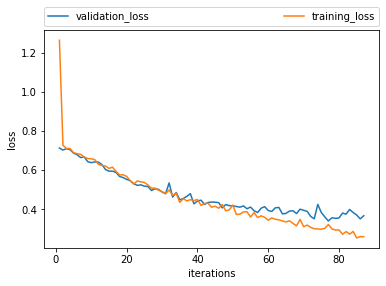

[0.7132742117952418,
 0.7027510537041558,
 0.7100691375909028,
 0.7046693740067659,
 0.6871057748794556,
 0.6788945992787679,
 0.664424788068842,
 0.6681987819848237,
 0.643779147554327,
 0.6383840971522861,
 0.6423320858566849,
 0.6412682798173692,
 0.6288731429311964,
 0.6039414825262847,
 0.5951002637545267,
 0.5954458272015607,
 0.5886671841144562,
 0.5680962414653213,
 0.5624939964877235,
 0.5532902291527501,
 0.5467980669604408,
 0.5313011474079556,
 0.5226723518636491,
 0.5254540277851952,
 0.5185570937615854,
 0.5170458875320576,
 0.4965397836985411,
 0.5054051931257602,
 0.5024507299617484,
 0.48895641609474466,
 0.4805554924187837,
 0.5350364214844174,
 0.46289106761967697,
 0.48643874790933395,
 0.44888736252431516,
 0.4560697807206048,
 0.4665132628546821,
 0.48054073475025316,
 0.42851370683422796,
 0.4427250689930386,
 0.4472996846393303,
 0.4254735090114452,
 0.43559325845153246,
 0.43757733592280634,
 0.43690568098315485,
 0.43459514887244616,
 0.4078495767381456,
 0.42

In [88]:
train_save('gender', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.2672138297557831, validation_error:0.7602468729019165
Best loss improvement from inf to 0.7602468729019165 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7440721011161804, validation_error:0.7138140838721703
Best loss improvement from 0.7602468729019165 to 0.7138140838721703 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7144497668743134, validation_error:0.7055950555308111
Best loss improvement from 0.7138140838721703 to 0.7055950555308111 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6989373040199279, validation_error:0.7009246924827839
Best loss improvement from 0.7055950555308111 to 0.7009246924827839 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6938278901576996, validation_error:0.6916975666736734
Best loss improvement from 0.7009246924827839 to 0.6916975666736734 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6893343472480774, v

minibatch:179, epoch:11, iteration:2699, training_error:0.3714281305670738, validation_error:0.35849812626838684
Best loss improvement from 0.3678420514895998 to 0.35849812626838684 in epoch 11
minibatch:229, epoch:11, iteration:2749, training_error:0.36659444093704224, validation_error:0.3662771238335248
minibatch:27, epoch:12, iteration:2799, training_error:0.3616751518845558, validation_error:0.38410145558159925
minibatch:77, epoch:12, iteration:2849, training_error:0.3437266290187836, validation_error:0.40497121677316467
minibatch:127, epoch:12, iteration:2899, training_error:0.3765683928132057, validation_error:0.3784923419870179
minibatch:177, epoch:12, iteration:2949, training_error:0.36127037554979324, validation_error:0.3585123224505063
minibatch:227, epoch:12, iteration:2999, training_error:0.36274526715278627, validation_error:0.3919437948999734
minibatch:25, epoch:13, iteration:3049, training_error:0.324932821393013, validation_error:0.3866874858223159
minibatch:75, epoch:1

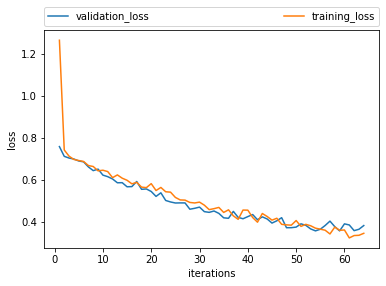

[0.7602468729019165,
 0.7138140838721703,
 0.7055950555308111,
 0.7009246924827839,
 0.6916975666736734,
 0.6876388829329918,
 0.6633389777150648,
 0.645669425355977,
 0.652864382184785,
 0.6243062060454796,
 0.6169209069219129,
 0.605913388318029,
 0.5877825473916942,
 0.5882163294430437,
 0.5687042741939939,
 0.5695895943148382,
 0.593876909593056,
 0.5566493581081259,
 0.558390626619602,
 0.5463126178445488,
 0.5228055859434193,
 0.5399386584758759,
 0.503424289925345,
 0.49635056997167654,
 0.4914108833362316,
 0.49184020942655104,
 0.4917478797764614,
 0.4617470955026561,
 0.4660736908172739,
 0.4718095341633106,
 0.45019380902421885,
 0.44678809622238425,
 0.4532412639979658,
 0.44192662937887783,
 0.4207343705769243,
 0.4184544076179636,
 0.4514171676389102,
 0.42279871373341,
 0.416313577314903,
 0.426529568330995,
 0.43635460837134,
 0.4117024828647745,
 0.42534880340099335,
 0.4152572900056839,
 0.3956759762147377,
 0.4065762239283529,
 0.4213497957278942,
 0.3735978364430625

In [89]:
train_save('gender', 1, 1)

In [ ]:
train_save('gender', 2, 1)

In [ ]:
train_save('gender', 3, 1)

In [ ]:
train_save('gender', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.2379946267604829, validation_error:0.7193384501669142
Best loss improvement from inf to 0.7193384501669142 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7282201266288757, validation_error:0.715153901665299
Best loss improvement from 0.7193384501669142 to 0.715153901665299 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.705384510755539, validation_error:0.6930669259141993
Best loss improvement from 0.715153901665299 to 0.6930669259141993 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7001119184494019, validation_error:0.6809361157593904
Best loss improvement from 0.6930669259141993 to 0.6809361157593904 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.699024007320404, validation_error:0.7201454639434814
minibatch:53, epoch:2, iteration:299, training_error:0.69082111120224, validation_error:0.6759947405921088
Best loss improvement from 0.6809361157593904 to 0.67

minibatch:239, epoch:11, iteration:2699, training_error:0.43357346534729, validation_error:0.4174907582777518
Best loss improvement from 0.4350528374866203 to 0.4174907582777518 in epoch 11
minibatch:43, epoch:12, iteration:2749, training_error:0.4318836748600006, validation_error:0.40945396820704144
Best loss improvement from 0.4174907582777518 to 0.40945396820704144 in epoch 12
minibatch:93, epoch:12, iteration:2799, training_error:0.4258468270301819, validation_error:0.42647263407707214
minibatch:143, epoch:12, iteration:2849, training_error:0.4370980906486511, validation_error:0.41730639338493347
minibatch:193, epoch:12, iteration:2899, training_error:0.43661850214004516, validation_error:0.41337769892480636
minibatch:243, epoch:12, iteration:2949, training_error:0.43283009111881254, validation_error:0.41000725163353813
minibatch:47, epoch:13, iteration:2999, training_error:0.423107345700264, validation_error:0.4104780709301984
minibatch:97, epoch:13, iteration:3049, training_error

minibatch:241, epoch:24, iteration:5899, training_error:0.29387268036603925, validation_error:0.3522671339688478
minibatch:45, epoch:25, iteration:5949, training_error:0.3020236137509346, validation_error:0.35757312675317127
minibatch:95, epoch:25, iteration:5999, training_error:0.28747269347310067, validation_error:0.3468358235226737
minibatch:145, epoch:25, iteration:6049, training_error:0.31053961992263795, validation_error:0.34669391258999155
minibatch:195, epoch:25, iteration:6099, training_error:0.2692527601122856, validation_error:0.34330178797245026
minibatch:245, epoch:25, iteration:6149, training_error:0.2911453454196453, validation_error:0.3492287259410929
minibatch:49, epoch:26, iteration:6199, training_error:0.2953751063346863, validation_error:0.3407040552960502
minibatch:99, epoch:26, iteration:6249, training_error:0.28772235348820685, validation_error:0.3489666525964384
minibatch:149, epoch:26, iteration:6299, training_error:0.27590796917676924, validation_error:0.33057

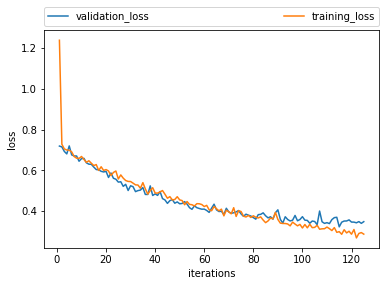

[0.7193384501669142,
 0.715153901665299,
 0.6930669259141993,
 0.6809361157593904,
 0.7201454639434814,
 0.6759947405921088,
 0.6710507251598217,
 0.6707114775975546,
 0.6450084182951186,
 0.6578422254986234,
 0.6590009133021036,
 0.63730756883268,
 0.6306018652739348,
 0.6299887145007098,
 0.6164038556593435,
 0.6043572889433967,
 0.6032043077327587,
 0.5957147964724788,
 0.5925559887179622,
 0.5954170867248818,
 0.5655031049693072,
 0.5875063704119788,
 0.5615544793782411,
 0.5569378921279201,
 0.5426996802842176,
 0.5445221441763418,
 0.5220111884452678,
 0.5318212155942563,
 0.5016102106482895,
 0.5248294803831313,
 0.520294373786008,
 0.49607934223281014,
 0.5011744344675982,
 0.5035848882463243,
 0.5160955223772261,
 0.48237396279970807,
 0.48218255352090905,
 0.5242983456011172,
 0.47722276603734054,
 0.48492201058952894,
 0.4775941460220902,
 0.4964151912265354,
 0.4619939415543168,
 0.45531920150474264,
 0.43860432174470687,
 0.45194230918531064,
 0.456744056057047,
 0.4393267

In [90]:
train_save('gender', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.2410342109203338, validation_error:0.756618740229771
Best loss improvement from inf to 0.756618740229771 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7227843260765076, validation_error:0.7311492603400658
Best loss improvement from 0.756618740229771 to 0.7311492603400658 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7125748980045319, validation_error:0.7035562786562689
Best loss improvement from 0.7311492603400658 to 0.7035562786562689 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7089877772331238, validation_error:0.7052145292019022
minibatch:249, epoch:1, iteration:249, training_error:0.708029408454895, validation_error:0.6979010557306224
Best loss improvement from 0.7035562786562689 to 0.6979010557306224 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.7015986132621765, validation_error:0.695717127158724
Best loss improvement from 0.6979010557306224 to 

minibatch:127, epoch:12, iteration:2899, training_error:0.4222541707754135, validation_error:0.3975418107262973
minibatch:177, epoch:12, iteration:2949, training_error:0.42103753209114075, validation_error:0.38590017680464117
Best loss improvement from 0.39401555986239994 to 0.38590017680464117 in epoch 12
minibatch:227, epoch:12, iteration:2999, training_error:0.43092128217220305, validation_error:0.38647159060527536
minibatch:25, epoch:13, iteration:3049, training_error:0.4360523951053619, validation_error:0.40108842993604726
minibatch:75, epoch:13, iteration:3099, training_error:0.408730525970459, validation_error:0.4122120825381115
minibatch:125, epoch:13, iteration:3149, training_error:0.40799385368824004, validation_error:0.3788096139143253
Best loss improvement from 0.38590017680464117 to 0.3788096139143253 in epoch 13
minibatch:175, epoch:13, iteration:3199, training_error:0.41335278153419497, validation_error:0.41419975099892453
minibatch:225, epoch:13, iteration:3249, trainin

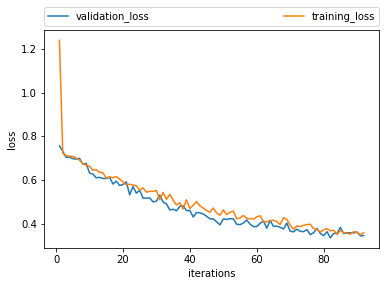

[0.756618740229771,
 0.7311492603400658,
 0.7035562786562689,
 0.7052145292019022,
 0.6979010557306224,
 0.695717127158724,
 0.6996307373046875,
 0.6732930726018446,
 0.6761771687145891,
 0.6322249544077906,
 0.6272188938897232,
 0.6103167944941027,
 0.6119700300282446,
 0.6069313472714918,
 0.6068485327835741,
 0.6122483970790074,
 0.5815801712973364,
 0.5946578085422516,
 0.5750223377655292,
 0.5790693287191719,
 0.5915716886520386,
 0.5319049810541088,
 0.5693750494513018,
 0.5396353849049272,
 0.5529267726273372,
 0.5168563733840811,
 0.5169627368450165,
 0.5175095868521723,
 0.49942062949312144,
 0.5027507040007361,
 0.5307234052954048,
 0.4987100126414463,
 0.49026900838161336,
 0.46270424230345364,
 0.4658883039293618,
 0.4585880637168884,
 0.4793852074392911,
 0.4822200834751129,
 0.45928091787058734,
 0.46036059486454933,
 0.4301858051069852,
 0.45081140357872534,
 0.4493544954678108,
 0.44405956617717085,
 0.43378072925682726,
 0.4218451863732831,
 0.42140872930658274,
 0.408

In [91]:
train_save('gender', 1, 2)

In [ ]:
train_save('gender', 2, 2)

In [ ]:
train_save('gender', 3, 2)

In [ ]:
train_save('gender', 4, 2)

In [92]:
print(get_performance_of_a_model("test", "gender", 0, 0))
print(get_performance_of_a_model("test", "gender", 1, 0))
#print(get_performance_of_a_model("test", "gender", 2, 0))
#print(get_performance_of_a_model("test", "gender", 3, 0))
#print(get_performance_of_a_model("test", "gender", 4, 0))

{'accuracy': 0.7748939356126778}
{'accuracy': 0.7770419426048565}


In [93]:
print(get_performance_of_a_model("test", "gender", 0, 1))
print(get_performance_of_a_model("test", "gender", 1, 1))
#print(get_performance_of_a_model("test", "gender", 2, 1))
#print(get_performance_of_a_model("test", "gender", 3, 1))
#print(get_performance_of_a_model("test", "gender", 4, 1))

{'accuracy': 0.7861242825056152}
{'accuracy': 0.7798013245033113}


In [94]:
print(get_performance_of_a_model("test", "gender", 0, 2))
print(get_performance_of_a_model("test", "gender", 1, 2))
#print(get_performance_of_a_model("test", "gender", 2, 2))
#print(get_performance_of_a_model("test", "gender", 3, 2))
#print(get_performance_of_a_model("test", "gender", 4, 2))

{'accuracy': 0.79760419266284}
{'accuracy': 0.7836644591611479}


In [95]:
print(get_performance_of_a_model("test", "age", 0, 0))
print(get_performance_of_a_model("test", "age", 1, 0))
print(get_performance_of_a_model("test", "age", 2, 0))
print(get_performance_of_a_model("test", "age", 3, 0))
print(get_performance_of_a_model("test", "age", 4, 0))

{'accuracy': 0.4284059314179796, 'one-off accuracy': 0.7131603336422614}
{'accuracy': 0.31473718155433733, 'one-off accuracy': 0.6881651080296678}
{'accuracy': 0.44624138963761606, 'one-off accuracy': 0.7376460017969452}
{'accuracy': 0.37411764705882355, 'one-off accuracy': 0.733109243697479}
{'accuracy': 0.40454914703493094, 'one-off accuracy': 0.7067424857839155}


In [96]:
print(get_performance_of_a_model("test", "age", 0, 1))
print(get_performance_of_a_model("test", "age", 1, 1))
print(get_performance_of_a_model("test", "age", 2, 1))
print(get_performance_of_a_model("test", "age", 3, 1))
print(get_performance_of_a_model("test", "age", 4, 1))

{'accuracy': 0.45134383688600554, 'one-off accuracy': 0.7594995366079703}
{'accuracy': 0.3514995162850693, 'one-off accuracy': 0.7258948726217349}
{'accuracy': 0.469601677148847, 'one-off accuracy': 0.7906558849955077}
{'accuracy': 0.3620168067226891, 'one-off accuracy': 0.7586554621848739}
{'accuracy': 0.4140265366910371, 'one-off accuracy': 0.7238017871649066}


In [97]:
print(get_performance_of_a_model("test", "age", 0, 2))
print(get_performance_of_a_model("test", "age", 1, 2))
print(get_performance_of_a_model("test", "age", 2, 2))
print(get_performance_of_a_model("test", "age", 3, 2))
print(get_performance_of_a_model("test", "age", 4, 2))

{'accuracy': 0.4580630213160334, 'one-off accuracy': 0.7571825764596849}
{'accuracy': 0.3469848435988391, 'one-off accuracy': 0.7258948726217349}
{'accuracy': 0.48247978436657685, 'one-off accuracy': 0.7792752321054208}
{'accuracy': 0.38857142857142857, 'one-off accuracy': 0.7465546218487394}
{'accuracy': 0.4237747089087463, 'one-off accuracy': 0.7332791768210127}


In [98]:
print(get_performance_of_a_model("test", "both", 0, 0))
print(get_performance_of_a_model("test", "both", 1, 0))
print(get_performance_of_a_model("test", "both", 2, 0))
print(get_performance_of_a_model("test", "both", 3, 0))
print(get_performance_of_a_model("test", "both", 4, 0))

{'accuracy': 0.29156999226604796, 'one-off accuracy': 0.5390564578499614, 'gender accuracy': 0.722866718226347, 'age accuracy': 0.3083268883732921, 'one-off age accuracy': 0.5978344934261408}
{'accuracy': 0.243261231281198, 'one-off accuracy': 0.5144758735440932, 'gender accuracy': 0.7460898502495841, 'age accuracy': 0.2605657237936772, 'one-off age accuracy': 0.5633943427620632}
{'accuracy': 0.2832425504645947, 'one-off accuracy': 0.5142582505607177, 'gender accuracy': 0.7071451457866068, 'age accuracy': 0.2950977250881128, 'one-off age accuracy': 0.5642422300544697}
{'accuracy': 0.28855547801814374, 'one-off accuracy': 0.599092812281926, 'gender accuracy': 0.7752965806001396, 'age accuracy': 0.2958827634333566, 'one-off age accuracy': 0.6280530355896721}
{'accuracy': 0.2736935341009743, 'one-off accuracy': 0.5033953351048125, 'gender accuracy': 0.7156775907883083, 'age accuracy': 0.2860938883968113, 'one-off age accuracy': 0.5429583702391497}


In [99]:
print(get_performance_of_a_model("test", "both", 0, 1))
print(get_performance_of_a_model("test", "both", 1, 1))
print(get_performance_of_a_model("test", "both", 2, 1))
print(get_performance_of_a_model("test", "both", 3, 1))
print(get_performance_of_a_model("test", "both", 4, 1))

{'accuracy': 0.32817736530033514, 'one-off accuracy': 0.5859757669502449, 'gender accuracy': 0.7512245424078371, 'age accuracy': 0.3431296725960299, 'one-off age accuracy': 0.6383088424851766}
{'accuracy': 0.2762063227953411, 'one-off accuracy': 0.5733777038269551, 'gender accuracy': 0.7603993344425957, 'age accuracy': 0.2951747088186356, 'one-off age accuracy': 0.6173044925124792}
{'accuracy': 0.2992630567125921, 'one-off accuracy': 0.5514258250560717, 'gender accuracy': 0.7353412367830824, 'age accuracy': 0.3098365908362704, 'one-off age accuracy': 0.5863505286767062}
{'accuracy': 0.2927424982554082, 'one-off accuracy': 0.6004884856943475, 'gender accuracy': 0.7829727843684577, 'age accuracy': 0.3018143754361479, 'one-off age accuracy': 0.6277041172365666}
{'accuracy': 0.27516976675524063, 'one-off accuracy': 0.5314437555358724, 'gender accuracy': 0.7392973132565692, 'age accuracy': 0.28520814880425155, 'one-off age accuracy': 0.5710067906702097}


In [100]:
print(get_performance_of_a_model("test", "both", 0, 2))
print(get_performance_of_a_model("test", "both", 1, 2))
print(get_performance_of_a_model("test", "both", 2, 2))
print(get_performance_of_a_model("test", "both", 3, 2))
print(get_performance_of_a_model("test", "both", 4, 2))

{'accuracy': 0.34931683423562776, 'one-off accuracy': 0.6246455271977314, 'gender accuracy': 0.7798401649909771, 'age accuracy': 0.35937097189997425, 'one-off age accuracy': 0.6553235369940706}
{'accuracy': 0.28186356073211316, 'one-off accuracy': 0.6086522462562396, 'gender accuracy': 0.7793677204658902, 'age accuracy': 0.2958402662229617, 'one-off age accuracy': 0.6439267886855241}
{'accuracy': 0.31207946171099005, 'one-off accuracy': 0.5555911566805511, 'gender accuracy': 0.7279718039090035, 'age accuracy': 0.3236142262095482, 'one-off age accuracy': 0.5978852931752643}
{'accuracy': 0.31856245638520586, 'one-off accuracy': 0.6224703419399861, 'gender accuracy': 0.8032100488485694, 'age accuracy': 0.32658757850662945, 'one-off age accuracy': 0.6482903000697837}
{'accuracy': 0.2887511071744907, 'one-off accuracy': 0.5653971065839977, 'gender accuracy': 0.7576025981694715, 'age accuracy': 0.29790374963094185, 'one-off age accuracy': 0.5949217596693239}


### How to run?

1.   **Run `train_save()`:**


> You can do this for different combinations of **`c`**, **`fold`**, and **`train_transform_index`**, where **`c={'age','gender'}`**, **`fold={0,1,2,3,4}`**, and **`train_transform_index={0,1,2}`**.

> I suggest you to first train the network on all the folds for **either** **`age`** or **`gender`** and then proceed to the setp 2. Then, follow the same steps for the other class. Also, use **`train_transform_index=2`** as it gives smaller validation error due to random flipping and cropping.

> **Note:** It is just the network's architecture that is the same for age and gender. They both are trained independently. Ultimately, we will be having two different networks with the same architecture, one to classify age and the other to classify gender.

2. **Picking the best model:**

> Call **`pick_best_model()`** on either **`age`** or **`gender`**.

3. **Know the performance:**

> Call **`get_performance()`** on either **`age`** or **`gender`** to know the final performance of the network on the test set.



